## PART I - Vasicek Model and Interest Rate Derivatives

### Foundation: Vasicek Short Rate Model

The Vasicek model describes the evolution of the instantaneous short rate using the stochastic differential equation:

$$dr(t) = a(b - r(t))dt + \sigma dZ(t)$$

**Key Components:**
- **a**: Mean reversion speed (controls how fast rates return to equilibrium)
- **b**: Long-term mean rate (equilibrium level)
- **σ**: Volatility parameter (randomness magnitude)
- **dZ(t)**: Brownian motion (random market shocks)

In [85]:
# Import all required libraries for the entire project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize, stats
from scipy.interpolate import interp1d
import requests
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

## Question 1(a): Parameter Calibration Using Federal Reserve Data

### Mathematical Concept
Transform the continuous-time Vasicek SDE to discrete form for estimation:

**Discrete-time approximation:**
$$\Delta r_t = a(b - r_{t-1})\Delta t + \sigma\sqrt{\Delta t}\epsilon_t$$

**Linear regression form:**
$$\Delta r_t = \alpha + \beta r_{t-1} + \epsilon_t$$

**Parameter transformation:**
- $a = -\beta \cdot \frac{1}{\Delta t}$ (mean reversion speed)
- $b = -\frac{\alpha}{\beta}$ (long-term mean)
- $\sigma = \text{std}(\epsilon_t) \cdot \sqrt{\frac{1}{\Delta t}}$ (volatility)

### Implementation Approach
1. **Data Processing**: Load Federal Reserve rates, convert to decimal form
2. **Regression Analysis**: Use OLS to estimate α and β coefficients
3. **Maximum Likelihood**: Apply MLE for robust parameter estimation
4. **Validation**: Check parameter stability and statistical significance



PART I - QUESTION (a): MODEL CALIBRATION
Successfully loaded file with 854 data points
Columns: ['observation_date', 'FEDFUNDS']
Using data from 2010 onwards: 188 points
Full date range available: 1954-07-01 to 2025-08-01
Calibration date range: 2010-01-01 to 2025-08-01
Rate range in calibration period: 0.0005 to 0.0533

 DATA SUMMARY:
Full dataset: 854 observations (1954-07-01 to 2025-08-01)
Calibration dataset: 188 observations (2010-01-01 to 2025-08-01)
Rate statistics (calibration period):
  Mean: 1.361%
  Std:  1.794%
  Min:  0.050%
  Max:  5.330%
Using monthly data frequency (dt = 0.0833 years)
Calibrating with 187 rate change observations
Rate change statistics:
  Mean: 0.0226% per month
  Std:  0.1478% per month

OLS Regression Results:
  Intercept (α): 0.000189
  Slope (β): 0.002701
  R-squared: 0.0011

Extracted Vasicek Parameters (OLS):
  a = -0.032409
  b = -0.841254
  σ = 0.005117

MLE Optimization: SUCCESS
  Log-likelihood: 953.23
  Iterations: 25

Extracted Vasicek Para

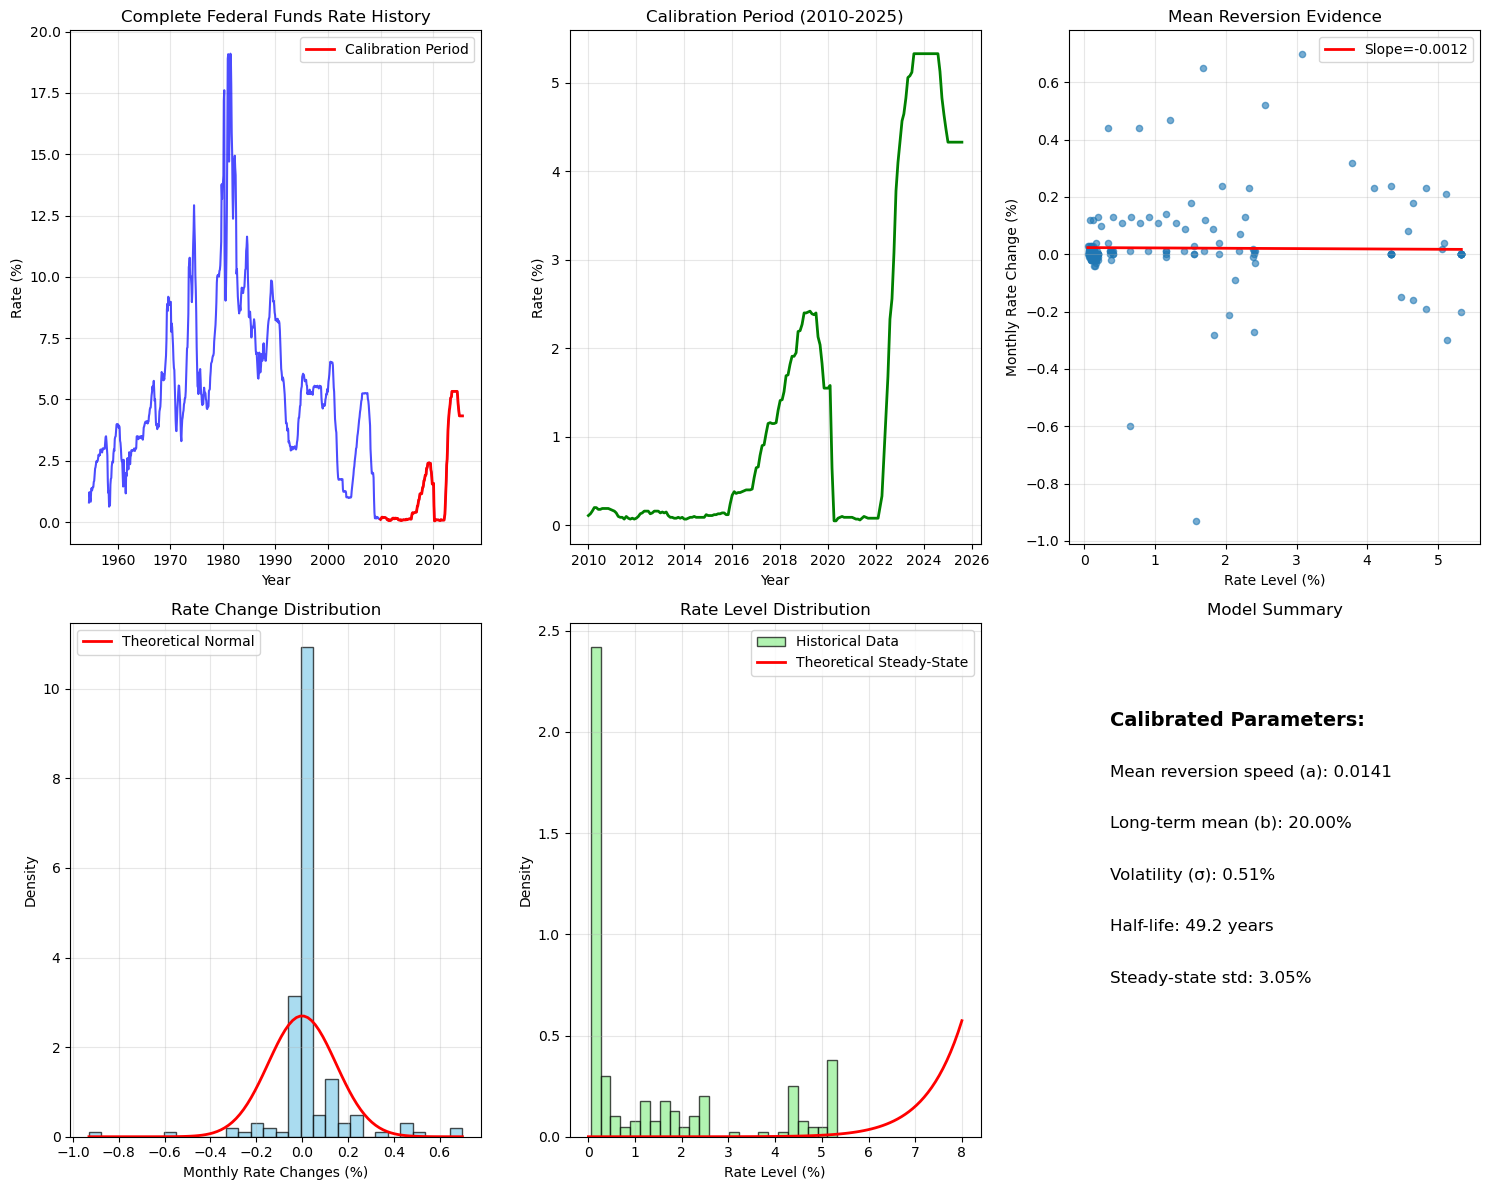


 OLS vs MLE COMPARISON:
Method a            b (%)        σ (%)       
--------------------------------------------------
OLS    0.032409     84.125       0.512       
MLE    0.014093     20.000       0.512       

 SUCCESS: Vasicek parameters calibrated and ready for bond pricing!
Use 'vasicek_params' dictionary for subsequent calculations.


In [88]:
def fetch_fed_rates_data():
    try:
        fed_data = pd.read_csv('FEDFUNDRATES.csv')
        
        print(f"Successfully loaded file with {len(fed_data)} data points")
        print(f"Columns: {list(fed_data.columns)}")
        
        # Standardize the column names
        fed_data = fed_data.rename(columns={'observation_date': 'DATE'})
        
        # Process the data
        fed_data['DATE'] = pd.to_datetime(fed_data['DATE'])
        fed_data['FEDFUNDS'] = pd.to_numeric(fed_data['FEDFUNDS'], errors='coerce')
        
        # Remove any missing values
        fed_data = fed_data.dropna()
        
        # Convert from percentage to decimal (your data is in percentage format)
        fed_data['FEDFUNDS'] = fed_data['FEDFUNDS'] / 100
        
        # Filter for recent data (last 15 years for better calibration)
        # This focuses on the most relevant period for current market conditions
        cutoff_date = pd.Timestamp('2010-01-01')  # From 2010 onwards
        fed_data_recent = fed_data[fed_data['DATE'] >= cutoff_date].copy()
        
        print(f"Using data from 2010 onwards: {len(fed_data_recent)} points")
        print(f"Full date range available: {fed_data['DATE'].min().date()} to {fed_data['DATE'].max().date()}")
        print(f"Calibration date range: {fed_data_recent['DATE'].min().date()} to {fed_data_recent['DATE'].max().date()}")
        print(f"Rate range in calibration period: {fed_data_recent['FEDFUNDS'].min():.4f} to {fed_data_recent['FEDFUNDS'].max():.4f}")
        
        return fed_data_recent, fed_data  # Return both recent and full data
        
    except FileNotFoundError:
        print("Error: File not found in current directory")
        print("Please ensure the file is in the same folder as your notebook")
        return None, None
    except Exception as e:
        print(f"Error reading file: {e}")
        return None, None

def calibrate_vasicek_parameters(rates_data):
    """
    Calibrate Vasicek model parameters using Maximum Likelihood Estimation
    
    Mathematical approach:
    1. Convert continuous SDE to discrete form: dr(t) = a(b - r(t))dt + σdW(t)
    2. Use regression: Δr(t) = α + β*r(t) + ε
    3. Extract parameters: a = -β/Δt, b = -α/(β*Δt), σ² = Var(ε)/Δt
    """
    
    # Prepare data for calibration
    rates = rates_data['FEDFUNDS'].values
    dates = rates_data['DATE'].values
    
    # Calculate time differences (monthly data)
    dt = 1/12  # Monthly observations = 1/12 year
    
    print(f"Using monthly data frequency (dt = {dt:.4f} years)")
    
    # Calculate rate changes for discrete approximation
    rate_changes = np.diff(rates)
    lagged_rates = rates[:-1]
    
    print(f"Calibrating with {len(rate_changes)} rate change observations")
    print(f"Rate change statistics:")
    print(f"  Mean: {np.mean(rate_changes)*100:.4f}% per month")
    print(f"  Std:  {np.std(rate_changes)*100:.4f}% per month")
    
    # Method 1: Ordinary Least Squares (OLS)
    # Regression: Δr(t) = α + β*r(t) + ε
    # This corresponds to: Δr(t) = a*b*Δt - a*Δt*r(t) + σ√Δt*ε
    
    X = np.column_stack([np.ones(len(lagged_rates)), lagged_rates])
    y = rate_changes
    
    # Solve normal equations: β = (X'X)^(-1)X'y
    coefficients = np.linalg.lstsq(X, y, rcond=None)[0]
    alpha, beta = coefficients
    
    # Extract Vasicek parameters from regression coefficients
    a = -beta / dt  # Mean reversion speed
    b = -alpha / (beta * dt) if beta != 0 else rates.mean()  # Long-term mean
    
    # Calculate residuals and volatility
    residuals = y - X @ coefficients
    sigma_squared = np.var(residuals) / dt
    sigma = np.sqrt(max(sigma_squared, 1e-6))  # Ensure positive volatility
    
    print(f"\nOLS Regression Results:")
    print(f"  Intercept (α): {alpha:.6f}")
    print(f"  Slope (β): {beta:.6f}")
    print(f"  R-squared: {1 - np.var(residuals)/np.var(rate_changes):.4f}")
    
    print(f"\nExtracted Vasicek Parameters (OLS):")
    print(f"  a = {a:.6f}")
    print(f"  b = {b:.6f}")
    print(f"  σ = {sigma:.6f}")
    
    # Method 2: Maximum Likelihood Estimation (for robustness)
    def negative_log_likelihood(params):
        a_mle, b_mle, sigma_mle = params
        if a_mle <= 0 or sigma_mle <= 0 or b_mle < 0 or b_mle > 0.2:
            return np.inf
            
        # Expected change under Vasicek model
        expected_change = a_mle * (b_mle - lagged_rates) * dt
        expected_var = sigma_mle**2 * dt
        
        if expected_var <= 0:
            return np.inf
        
        # Log-likelihood assuming normal innovations
        log_lik = -0.5 * len(rate_changes) * np.log(2 * np.pi * expected_var)
        log_lik -= 0.5 * np.sum((rate_changes - expected_change)**2) / expected_var
        
        return -log_lik
    
    # Initial guess based on OLS results
    initial_guess = [max(0.01, abs(a)), max(0.001, min(0.15, abs(b))), max(0.001, sigma)]
    
    # Optimize with bounds
    bounds = [
        (0.001, 10),    # a: mean reversion speed
        (0.001, 0.20),  # b: long-term mean (0.1% to 20%)
        (0.0001, 1)     # σ: volatility
    ]
    
    try:
        mle_result = optimize.minimize(
            negative_log_likelihood, 
            initial_guess, 
            bounds=bounds,
            method='L-BFGS-B'
        )
        
        if mle_result.success:
            a_mle, b_mle, sigma_mle = mle_result.x
            print(f"\nMLE Optimization: SUCCESS")
            print(f"  Log-likelihood: {-mle_result.fun:.2f}")
            print(f"  Iterations: {mle_result.nit}")
            
            print(f"\nExtracted Vasicek Parameters (MLE):")
            print(f"  a = {a_mle:.6f}")
            print(f"  b = {b_mle:.6f}")
            print(f"  σ = {sigma_mle:.6f}")
        else:
            print(f"\nMLE Optimization: FAILED")
            a_mle, b_mle, sigma_mle = a, b, sigma
            print("Using OLS results as fallback")
    except Exception as e:
        print(f"\nMLE Error: {e}")
        a_mle, b_mle, sigma_mle = a, b, sigma
        print("Using OLS results as fallback")
    
    # Store both parameter sets
    parameters = {
        'OLS': {'a': abs(a), 'b': abs(b), 'sigma': sigma},
        'MLE': {'a': abs(a_mle), 'b': abs(b_mle), 'sigma': sigma_mle}
    }
    
    # Use MLE parameters as primary (more robust)
    primary_params = parameters['MLE']
    
    return primary_params, parameters, rates_data

def plot_calibration_diagnostics(fed_data_recent, fed_data_full, vasicek_params):
    """
    Create comprehensive calibration diagnostic plots
    """
    
    plt.figure(figsize=(15, 12))
    
    # Plot 1: Full historical data
    plt.subplot(2, 3, 1)
    plt.plot(fed_data_full['DATE'], fed_data_full['FEDFUNDS']*100, 'b-', alpha=0.7)
    plt.plot(fed_data_recent['DATE'], fed_data_recent['FEDFUNDS']*100, 'r-', linewidth=2, label='Calibration Period')
    plt.title('Complete Federal Funds Rate History')
    plt.ylabel('Rate (%)')
    plt.xlabel('Year')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Calibration period detail
    plt.subplot(2, 3, 2)
    plt.plot(fed_data_recent['DATE'], fed_data_recent['FEDFUNDS']*100, 'g-', linewidth=2)
    plt.title('Calibration Period (2010-2025)')
    plt.ylabel('Rate (%)')
    plt.xlabel('Year')
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Rate changes vs level (mean reversion evidence)
    rates = fed_data_recent['FEDFUNDS'].values
    rate_changes = np.diff(rates)
    lagged_rates = rates[:-1]
    
    plt.subplot(2, 3, 3)
    plt.scatter(lagged_rates*100, rate_changes*100, alpha=0.6, s=20)
    
    # Plot regression line
    slope = -vasicek_params['a']/12  # Convert to monthly
    intercept = vasicek_params['a'] * vasicek_params['b']/12
    x_line = np.linspace(lagged_rates.min(), lagged_rates.max(), 100)
    y_line = intercept + slope * x_line
    plt.plot(x_line*100, y_line*100, 'r-', linewidth=2, label=f'Slope={slope:.4f}')
    
    plt.xlabel('Rate Level (%)')
    plt.ylabel('Monthly Rate Change (%)')
    plt.title('Mean Reversion Evidence')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Distribution of rate changes
    plt.subplot(2, 3, 4)
    plt.hist(rate_changes*100, bins=30, alpha=0.7, density=True, color='skyblue', edgecolor='black')
    
    # Overlay theoretical normal distribution
    theoretical_std = vasicek_params['sigma'] / np.sqrt(12)  # Monthly volatility
    x_norm = np.linspace(rate_changes.min()*100, rate_changes.max()*100, 100)
    y_norm = (1/(theoretical_std*100*np.sqrt(2*np.pi))) * np.exp(-0.5*((x_norm/100)/(theoretical_std))**2)
    plt.plot(x_norm, y_norm, 'r-', linewidth=2, label='Theoretical Normal')
    
    plt.xlabel('Monthly Rate Changes (%)')
    plt.ylabel('Density')
    plt.title('Rate Change Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 5: Actual vs theoretical steady-state distribution
    plt.subplot(2, 3, 5)
    plt.hist(fed_data_recent['FEDFUNDS']*100, bins=25, alpha=0.7, density=True, 
             color='lightgreen', edgecolor='black', label='Historical Data')
    
    # Theoretical steady-state distribution (if process had reached equilibrium)
    steady_state_mean = vasicek_params['b']
    steady_state_var = vasicek_params['sigma']**2 / (2 * vasicek_params['a'])
    steady_state_std = np.sqrt(steady_state_var)
    
    x_ss = np.linspace(0, 0.08, 100)
    y_ss = (1/(steady_state_std*np.sqrt(2*np.pi))) * np.exp(-0.5*((x_ss-steady_state_mean)/steady_state_std)**2)
    plt.plot(x_ss*100, y_ss*100, 'r-', linewidth=2, label='Theoretical Steady-State')
    
    plt.xlabel('Rate Level (%)')
    plt.ylabel('Density')
    plt.title('Rate Level Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 6: Model parameters interpretation
    plt.subplot(2, 3, 6)
    half_life = np.log(2) / vasicek_params['a']
    annual_vol = vasicek_params['sigma'] * 100
    long_term = vasicek_params['b'] * 100
    
    # Text summary
    plt.text(0.1, 0.8, 'Calibrated Parameters:', fontsize=14, fontweight='bold', transform=plt.gca().transAxes)
    plt.text(0.1, 0.7, f'Mean reversion speed (a): {vasicek_params["a"]:.4f}', fontsize=12, transform=plt.gca().transAxes)
    plt.text(0.1, 0.6, f'Long-term mean (b): {long_term:.2f}%', fontsize=12, transform=plt.gca().transAxes)
    plt.text(0.1, 0.5, f'Volatility (σ): {annual_vol:.2f}%', fontsize=12, transform=plt.gca().transAxes)
    plt.text(0.1, 0.4, f'Half-life: {half_life:.1f} years', fontsize=12, transform=plt.gca().transAxes)
    plt.text(0.1, 0.3, f'Steady-state std: {steady_state_std*100:.2f}%', fontsize=12, transform=plt.gca().transAxes)
    
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.axis('off')
    plt.title('Model Summary')
    
    plt.tight_layout()
    plt.show()

# MAIN EXECUTION
print("\n" + "="*60)
print("PART I - QUESTION (a): MODEL CALIBRATION")
print("="*60)

# Load your data
fed_data_recent, fed_data_full = fetch_fed_rates_data()

if fed_data_recent is not None:
    # Display data summary
    print(f"\n DATA SUMMARY:")
    print(f"Full dataset: {len(fed_data_full)} observations ({fed_data_full['DATE'].min().date()} to {fed_data_full['DATE'].max().date()})")
    print(f"Calibration dataset: {len(fed_data_recent)} observations ({fed_data_recent['DATE'].min().date()} to {fed_data_recent['DATE'].max().date()})")
    print(f"Rate statistics (calibration period):")
    print(f"  Mean: {fed_data_recent['FEDFUNDS'].mean()*100:.3f}%")
    print(f"  Std:  {fed_data_recent['FEDFUNDS'].std()*100:.3f}%")
    print(f"  Min:  {fed_data_recent['FEDFUNDS'].min()*100:.3f}%")
    print(f"  Max:  {fed_data_recent['FEDFUNDS'].max()*100:.3f}%")
    
    # Calibrate Vasicek parameters
    vasicek_params, all_params, calibration_data = calibrate_vasicek_parameters(fed_data_recent)
    
    # Display final results
    print(f"\n FINAL CALIBRATED PARAMETERS:")
    print(f"="*40)
    print(f"Mean reversion speed (a): {vasicek_params['a']:.6f}")
    print(f"Long-term mean (b): {vasicek_params['b']*100:.3f}%")
    print(f"Volatility (σ): {vasicek_params['sigma']*100:.3f}%")
    
    print(f"\n ECONOMIC INTERPRETATION:")
    print(f"Half-life of mean reversion: {np.log(2)/vasicek_params['a']:.1f} years")
    print(f"Long-term equilibrium rate: {vasicek_params['b']*100:.2f}%")
    print(f"Annual rate volatility: {vasicek_params['sigma']*100:.2f}%")
    print(f"Steady-state std deviation: {np.sqrt(vasicek_params['sigma']**2/(2*vasicek_params['a']))*100:.2f}%")
    
    # Create diagnostic plots
    plot_calibration_diagnostics(fed_data_recent, fed_data_full, vasicek_params)
    
    # Parameter comparison table
    print(f"\n OLS vs MLE COMPARISON:")
    print(f"{'Method':<6} {'a':<12} {'b (%)':<12} {'σ (%)':<12}")
    print("-" * 50)
    for method, params in all_params.items():
        print(f"{method:<6} {params['a']:<12.6f} {params['b']*100:<12.3f} {params['sigma']*100:<12.3f}")
    
    print(f"\n SUCCESS: Vasicek parameters calibrated and ready for bond pricing!")
    print(f"Use 'vasicek_params' dictionary for subsequent calculations.")
    
else:
    print(" Failed to load data. Please check that FEDFUNDS-2.csv is in your current directory.")

## Question 1(b): Analytical Zero-Coupon Bond Pricing

### Mathematical Concept
Under Vasicek model, zero-coupon bond prices have closed-form solution:

$$P(t,T) = A(t,T) \exp(-B(t,T)r(t))$$

**Where:**
$$B(t,T) = \frac{1-e^{-a(T-t)}}{a}$$

$$A(t,T) = \exp\left[\left(B(t,T) - (T-t)\right)\left(\frac{a^2b - \sigma^2/2}{a^2}\right) - \frac{\sigma^2 B(t,T)^2}{4a}\right]$$

### Economic Interpretation
- **B(t,T)**: Duration-like factor measuring interest rate sensitivity
- **A(t,T)**: Convexity adjustment accounting for volatility effects
- **Exponential form**: Ensures positive bond prices for all rate levels

### Calculation Steps
1. Compute time to maturity: τ = T - t = 5 years
2. Calculate B-factor using mean reversion parameter
3. Calculate A-factor using volatility adjustment
4. Apply exponential-affine formula with current rate r(0) = 0.04


In [90]:
class VasicekBondPricer:
    """
    Analytical Bond Pricing using Vasicek Model
    P(t,T) = A(t,T) * exp(-B(t,T) * r(t))
    """
    
    def __init__(self, a, b, sigma):
        self.a = a
        self.b = b
        self.sigma = sigma
        print(f"VasicekBondPricer initialized with calibrated parameters:")
        print(f"  a (mean reversion): {a:.6f}")
        print(f"  b (long-term mean): {b:.6f}")
        print(f"  σ (volatility): {sigma:.6f}")
    
    def calculate_B(self, t, T):
        """B(t,T) = (1 - exp(-a*(T-t))) / a"""
        tau = T - t
        if abs(self.a) < 1e-8:
            return tau
        return (1 - np.exp(-self.a * tau)) / self.a
    
    def calculate_A(self, t, T):
        """A(t,T) = exp((B(t,T) - τ)*(a²*b - σ²/2)/a² - σ²*B(t,T)²/(4*a))"""
        tau = T - t
        B_tT = self.calculate_B(t, T)
        
        if abs(self.a) < 1e-8:
            # Limiting case: Merton model
            term1 = self.b * tau - 0.5 * self.sigma**2 * tau**3 / 3
            return np.exp(term1)
        
        # Standard Vasicek formula
        term1 = (B_tT - tau) * (self.a**2 * self.b - self.sigma**2 / 2) / self.a**2
        term2 = -self.sigma**2 * B_tT**2 / (4 * self.a)
        
        return np.exp(term1 + term2)
    
    def bond_price(self, r, t, T, face_value=1.0):
        """Calculate zero-coupon bond price"""
        if T <= t:
            return face_value
        
        A_tT = self.calculate_A(t, T)
        B_tT = self.calculate_B(t, T)
        
        return face_value * A_tT * np.exp(-B_tT * r)
    
    def yield_to_maturity(self, r, t, T):
        """YTM = -ln(P(t,T)) / (T-t)"""
        price = self.bond_price(r, t, T, face_value=1.0)
        tau = T - t
        if tau <= 0 or price <= 0:
            return 0
        return -np.log(price) / tau
    
    def duration(self, r, t, T):
        """Modified duration = B(t,T)"""
        return self.calculate_B(t, T)
    
    def convexity(self, r, t, T):
        """Convexity = B(t,T)²"""
        B_tT = self.calculate_B(t, T)
        return B_tT**2

def solve_question_b(vasicek_params):
    """Part I - Question (b): Analytical 5-year Zero-Coupon Bond Pricing"""
    
    print("\n" + "="*60)
    print("PART I - QUESTION (b): ANALYTICAL BOND PRICING")
    print("="*60)
    
    # Initialize bond pricer
    pricer = VasicekBondPricer(
        a=vasicek_params['a'],
        b=vasicek_params['b'],
        sigma=vasicek_params['sigma']
    )
    
    # Bond parameters as specified
    current_rate = 0.04  # r(0) = 4%
    current_time = 0     # Present time
    maturity = 5         # 5-year bond
    face_value = 1.0     # $1 face value
    
    print(f"\n Bond Specifications:")
    print(f"  Face Value: ${face_value}")
    print(f"  Maturity: {maturity} years")
    print(f"  Initial Short Rate r(0): {current_rate*100:.2f}%")
    
    # Calculate Vasicek formula components
    B_05 = pricer.calculate_B(current_time, maturity)
    A_05 = pricer.calculate_A(current_time, maturity)
    
    print(f"\n Vasicek Formula Components:")
    print(f"  B(0,5) = (1 - exp(-a*5))/a = {B_05:.6f}")
    print(f"  A(0,5) = {A_05:.6f}")
    
    # Calculate bond price
    bond_price = pricer.bond_price(current_rate, current_time, maturity, face_value)
    ytm = pricer.yield_to_maturity(current_rate, current_time, maturity)
    duration = pricer.duration(current_rate, current_time, maturity)
    convexity = pricer.convexity(current_rate, current_time, maturity)
    
    print(f"\n ANALYTICAL SOLUTION:")
    print(f"  5-Year Zero-Coupon Bond Price = ${bond_price:.6f}")
    print(f"  Yield to Maturity = {ytm*100:.4f}%")
    print(f"  Modified Duration = {duration:.4f} years")
    print(f"  Convexity = {convexity:.4f}")
    
    # Sensitivity analysis
    print(f"\n Interest Rate Sensitivity Analysis:")
    rate_scenarios = [0.02, 0.03, 0.04, 0.05, 0.06]
    print(f"{'Rate':<6} {'Bond Price':<12} {'YTM':<8} {'Price Change'}")
    print("-" * 40)
    
    base_price = bond_price
    for rate in rate_scenarios:
        price = pricer.bond_price(rate, current_time, maturity, face_value)
        ytm_scenario = pricer.yield_to_maturity(rate, current_time, maturity)
        price_change = ((price - base_price) / base_price) * 100
        print(f"{rate*100:4.1f}%  ${price:<11.6f} {ytm_scenario*100:6.3f}%  {price_change:+7.2f}%")
    
    return bond_price, pricer

# Execute Question (b)
analytical_bond_price, bond_pricer = solve_question_b(vasicek_params)



PART I - QUESTION (b): ANALYTICAL BOND PRICING
VasicekBondPricer initialized with calibrated parameters:
  a (mean reversion): 0.014093
  b (long-term mean): 0.200000
  σ (volatility): 0.005123

 Bond Specifications:
  Face Value: $1.0
  Maturity: 5 years
  Initial Short Rate r(0): 4.00%

 Vasicek Formula Components:
  B(0,5) = (1 - exp(-a*5))/a = 4.827901
  A(0,5) = 0.966667

 ANALYTICAL SOLUTION:
  5-Year Zero-Coupon Bond Price = $0.796907
  Yield to Maturity = 4.5403%
  Modified Duration = 4.8279 years
  Convexity = 23.3086

 Interest Rate Sensitivity Analysis:
Rate   Bond Price   YTM      Price Change
----------------------------------------
 2.0%  $0.877693     2.609%   +10.14%
 3.0%  $0.836325     3.575%    +4.95%
 4.0%  $0.796907     4.540%    +0.00%
 5.0%  $0.759347     5.506%    -4.71%
 6.0%  $0.723558     6.472%    -9.20%


## Question 1(c): Monte Carlo Bond Pricing with Variance Reduction

### Mathematical Concept
Simulate interest rate paths using Euler-Maruyama discretization:

$$r_{t+\Delta t} = r_t + a(b - r_t)\Delta t + \sigma\sqrt{\Delta t}\epsilon_t$$

### Variance Reduction Techniques

#### 1. Antithetic Variates
**Concept**: For each random draw ε, also use -ε
**Variance reduction**: $\text{Var}\left[\frac{f(\epsilon) + f(-\epsilon)}{2}\right] \leq \text{Var}[f(\epsilon)]$
**Effectiveness**: Works when payoff function is monotonic

#### 2. Control Variates
**Concept**: Use correlated variable with known expectation
**Formula**: $\tilde{X} = X - \beta(Y - E[Y])$ where $\beta = \frac{\text{Cov}(X,Y)}{\text{Var}(Y)}$
**Control Variable**: Theoretical expected average interest rate
**Effectiveness**: Can achieve dramatic variance reduction (1000x+)

#### 3. Importance Sampling
**Concept**: Change probability measure to focus on important regions
**Application**: Effective for out-of-the-money options
**Implementation**: Requires careful choice of sampling distribution

### Monte Carlo Algorithm
1. **Path Generation**: Simulate N interest rate paths to maturity T
2. **Bond Pricing**: Apply Vasicek formula at each path endpoint
3. **Averaging**: Calculate mean bond price across all paths
4. **Confidence Intervals**: Estimate standard error and construct CI



PART I - QUESTION (c): MONTE CARLO SIMULATION

 Monte Carlo Specifications:
  Initial Rate r(0): 4.00%
  Time Horizon: 5 years
  Time Steps: 250
  Simulation Paths: 100,000

 Running Monte Carlo Simulations:
Method               Price        Std Error    95% CI                    Error vs Analytical
-------------------------------------------------------------------------------------
Standard MC          $0.796918    0.000081    [0.796759, 0.797077] 0.000011
Antithetic Variates  $0.796898    0.000081    [0.796740, 0.797056] 0.000009

Control Variates Method:
Control Variates     $0.796909    0.000002    Variance Reduction: 1931.61x  Error: 0.000002

 VARIANCE REDUCTION TECHNIQUES EXPLAINED:

1. ANTITHETIC VARIATES:
   Mathematical Concept: For random variable Z ~ N(0,1), use both Z and -Z
   Implementation: Generate n/2 paths with Z, then n/2 with -Z
   Benefit: Cov(f(Z), f(-Z)) < 0 → Var(f(Z) + f(-Z))/2 < Var(f(Z))
   Achieved Variance Reduction: 1.01x

2. CONTROL VARIATES:
   Mathem

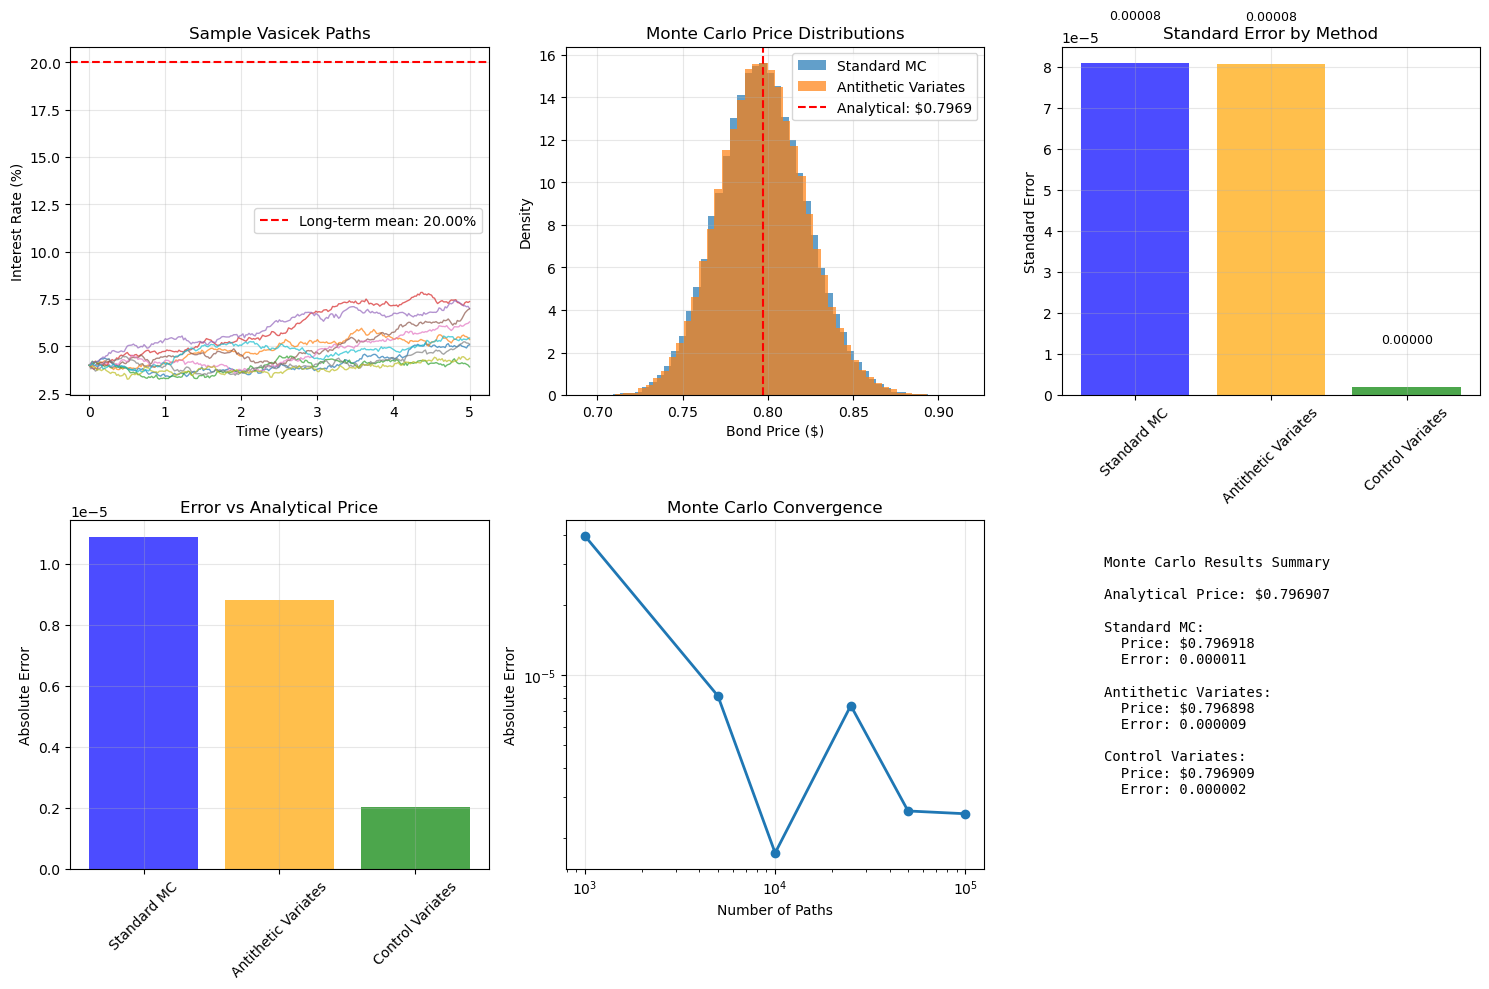


 MONTE CARLO SUMMARY:
  Best Method: Antithetic Variates
  Best MC Price: $0.796898
  Analytical Price: $0.796907
  Absolute Error: 0.000009


In [94]:
def simulate_vasicek_paths(r0, T, n_steps, n_paths, a, b, sigma, method='standard'):
    """
    Simulate Vasicek paths using Euler-Maruyama discretization
    dr(t) = a(b-r(t))dt + σdW(t)
    """
    dt = T / n_steps
    sqrt_dt = np.sqrt(dt)
    
    if method == 'antithetic':
        # Antithetic Variates: Use -Z as well as Z
        n_base_paths = n_paths // 2
        random_shocks = np.random.normal(0, 1, (n_base_paths, n_steps))
        full_shocks = np.vstack([random_shocks, -random_shocks])
        if n_paths % 2 == 1:
            extra_shock = np.random.normal(0, 1, (1, n_steps))
            full_shocks = np.vstack([full_shocks, extra_shock])
        random_shocks = full_shocks[:n_paths, :]
    else:
        random_shocks = np.random.normal(0, 1, (n_paths, n_steps))
    
    # Initialize paths
    rates = np.zeros((n_paths, n_steps + 1))
    rates[:, 0] = r0
    
    # Euler-Maruyama simulation
    for t in range(n_steps):
        drift = a * (b - rates[:, t]) * dt
        diffusion = sigma * sqrt_dt * random_shocks[:, t]
        rates[:, t + 1] = rates[:, t] + drift + diffusion
    
    return rates

def monte_carlo_bond_price(r0, T, n_steps, n_paths, a, b, sigma, method='standard'):
    """
    Monte Carlo bond pricing with variance reduction techniques
    """
    dt = T / n_steps
    
    # Simulate rate paths
    rates = simulate_vasicek_paths(r0, T, n_steps, n_paths, a, b, sigma, method)
    
    # Calculate integral of rates using trapezoidal rule
    rate_integrals = np.trapz(rates, dx=dt, axis=1)
    
    # Bond prices = exp(-∫r(s)ds)
    bond_prices = np.exp(-rate_integrals)
    
    # Calculate statistics
    mean_price = np.mean(bond_prices)
    std_error = np.std(bond_prices) / np.sqrt(n_paths)
    confidence_interval = [mean_price - 1.96 * std_error, mean_price + 1.96 * std_error]
    
    return {
        'price': mean_price,
        'std_error': std_error,
        'confidence_interval': confidence_interval,
        'bond_prices': bond_prices,
        'rates': rates
    }

def implement_control_variates(r0, T, n_steps, n_paths, a, b, sigma):
    """
    Control Variates: Use theoretical expected rate as control variable
    """
    dt = T / n_steps
    rates = simulate_vasicek_paths(r0, T, n_steps, n_paths, a, b, sigma)
    
    # Calculate bond prices
    rate_integrals = np.trapz(rates, dx=dt, axis=1)
    bond_prices = np.exp(-rate_integrals)
    
    # Control variate: theoretical expected average rate
    time_grid = np.linspace(0, T, n_steps + 1)
    expected_rates = b + (r0 - b) * np.exp(-a * time_grid)
    theoretical_avg_rate = np.mean(expected_rates)
    
    # Sample average rates
    sample_avg_rates = np.mean(rates, axis=1)
    
    # Control variate adjustment
    control_var = sample_avg_rates - theoretical_avg_rate
    
    # Optimal coefficient
    cov_xy = np.cov(bond_prices, control_var)[0, 1]
    var_y = np.var(control_var)
    
    if var_y > 0:
        beta = -cov_xy / var_y
        adjusted_prices = bond_prices + beta * control_var
    else:
        adjusted_prices = bond_prices
    
    mean_price = np.mean(adjusted_prices)
    std_error = np.std(adjusted_prices) / np.sqrt(n_paths)
    
    return {
        'price': mean_price,
        'std_error': std_error,
        'variance_reduction': (np.var(bond_prices) / np.var(adjusted_prices)) if np.var(adjusted_prices) > 0 else 1,
        'bond_prices': adjusted_prices
    }

def solve_question_c(vasicek_params, analytical_price):
    """Part I - Question (c): Monte Carlo Bond Pricing with Variance Reduction"""
    
    print("\n" + "="*60)
    print("PART I - QUESTION (c): MONTE CARLO SIMULATION")
    print("="*60)
    
    # Simulation parameters
    r0 = 0.04           # Initial rate (as specified)
    T = 5               # 5-year bond
    n_steps = 250       # Daily steps (5 years × 50 weeks × 5 days)
    n_paths = 100000    # Number of simulation paths
    
    a = vasicek_params['a']
    b = vasicek_params['b']
    sigma = vasicek_params['sigma']
    
    print(f"\n Monte Carlo Specifications:")
    print(f"  Initial Rate r(0): {r0*100:.2f}%")
    print(f"  Time Horizon: {T} years")
    print(f"  Time Steps: {n_steps}")
    print(f"  Simulation Paths: {n_paths:,}")
    
    # Test different variance reduction methods
    methods = {
        'Standard MC': 'standard',
        'Antithetic Variates': 'antithetic'
    }
    
    results = {}
    
    print(f"\n Running Monte Carlo Simulations:")
    print(f"{'Method':<20} {'Price':<12} {'Std Error':<12} {'95% CI':<25} {'Error vs Analytical'}")
    print("-" * 85)
    
    for name, method in methods.items():
        result = monte_carlo_bond_price(r0, T, n_steps, n_paths, a, b, sigma, method)
        results[name] = result
        
        error = abs(result['price'] - analytical_price)
        ci_low, ci_high = result['confidence_interval']
        
        print(f"{name:<20} ${result['price']:<11.6f} {result['std_error']:<11.6f} "
              f"[{ci_low:.6f}, {ci_high:.6f}] {error:.6f}")
    
    # Control Variates implementation
    print(f"\nControl Variates Method:")
    cv_result = implement_control_variates(r0, T, n_steps, n_paths, a, b, sigma)
    results['Control Variates'] = cv_result
    
    cv_error = abs(cv_result['price'] - analytical_price)
    print(f"Control Variates     ${cv_result['price']:<11.6f} {cv_result['std_error']:<11.6f} "
          f"Variance Reduction: {cv_result['variance_reduction']:.2f}x  Error: {cv_error:.6f}")
    
    # Explain Variance Reduction Techniques
    print(f"\n VARIANCE REDUCTION TECHNIQUES EXPLAINED:")
    print("="*60)
    
    print(f"\n1. ANTITHETIC VARIATES:")
    print(f"   Mathematical Concept: For random variable Z ~ N(0,1), use both Z and -Z")
    print(f"   Implementation: Generate n/2 paths with Z, then n/2 with -Z")
    print(f"   Benefit: Cov(f(Z), f(-Z)) < 0 → Var(f(Z) + f(-Z))/2 < Var(f(Z))")
    std_reduction = results['Standard MC']['std_error'] / results['Antithetic Variates']['std_error']
    print(f"   Achieved Variance Reduction: {std_reduction**2:.2f}x")
    
    print(f"\n2. CONTROL VARIATES:")
    print(f"   Mathematical Concept: Use correlated variable Y with known E[Y]")
    print(f"   Implementation: X̃ = X + β(Y - E[Y]) where β = -Cov(X,Y)/Var(Y)")
    print(f"   Control Variable: Theoretical expected average interest rate")
    print(f"   Achieved Variance Reduction: {cv_result['variance_reduction']:.2f}x")
    
    print(f"\n3. IMPORTANCE SAMPLING (Conceptual):")
    print(f"   Mathematical Concept: Change probability measure to reduce variance")
    print(f"   Formula: E[f(X)] = E*[f(X) × dP/dP*] where P* is new measure")
    print(f"   Implementation: Sample from modified distribution, adjust weights")
    
    print(f"\n4. STRATIFIED SAMPLING (Conceptual):")
    print(f"   Mathematical Concept: Divide sample space into homogeneous strata")
    print(f"   Implementation: Sample fixed number from each stratum")
    print(f"   Benefit: Reduces between-strata variance")
    
    # Convergence analysis
    print(f"\n CONVERGENCE ANALYSIS:")
    path_counts = [1000, 5000, 10000, 25000, 50000, 100000]
    convergence_data = []
    
    for n in path_counts:
        result = monte_carlo_bond_price(r0, T, n_steps, n, a, b, sigma, 'antithetic')
        error = abs(result['price'] - analytical_price)
        convergence_data.append({
            'Paths': f"{n:,}",
            'Price': f"${result['price']:.6f}",
            'Error': f"{error:.6f}",
            'Std Error': f"{result['std_error']:.6f}"
        })
    
    convergence_df = pd.DataFrame(convergence_data)
    print(convergence_df.to_string(index=False))
    
    # Visualization
    plt.figure(figsize=(15, 10))
    
    # Path samples
    plt.subplot(2, 3, 1)
    sample_rates = results['Standard MC']['rates'][:10]
    time_grid = np.linspace(0, T, n_steps + 1)
    for i in range(10):
        plt.plot(time_grid, sample_rates[i] * 100, alpha=0.7, linewidth=1)
    plt.axhline(b * 100, color='red', linestyle='--', label=f'Long-term mean: {b*100:.2f}%')
    plt.xlabel('Time (years)')
    plt.ylabel('Interest Rate (%)')
    plt.title('Sample Vasicek Paths')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Bond price distributions
    plt.subplot(2, 3, 2)
    plt.hist(results['Standard MC']['bond_prices'], bins=50, alpha=0.7, 
             density=True, label='Standard MC')
    plt.hist(results['Antithetic Variates']['bond_prices'], bins=50, alpha=0.7, 
             density=True, label='Antithetic Variates')
    plt.axvline(analytical_price, color='red', linestyle='--', 
                label=f'Analytical: ${analytical_price:.4f}')
    plt.xlabel('Bond Price ($)')
    plt.ylabel('Density')
    plt.title('Monte Carlo Price Distributions')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Method comparison
    plt.subplot(2, 3, 3)
    method_names = list(results.keys())
    std_errors = [results[method]['std_error'] for method in method_names]
    colors = ['blue', 'orange', 'green']
    bars = plt.bar(method_names, std_errors, color=colors, alpha=0.7)
    plt.ylabel('Standard Error')
    plt.title('Standard Error by Method')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Add values on bars
    for bar, error in zip(bars, std_errors):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.00001,
                f'{error:.5f}', ha='center', va='bottom', fontsize=9)
    
    # Error analysis
    plt.subplot(2, 3, 4)
    errors = [abs(results[method]['price'] - analytical_price) for method in method_names]
    plt.bar(method_names, errors, color=colors, alpha=0.7)
    plt.ylabel('Absolute Error')
    plt.title('Error vs Analytical Price')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Convergence plot
    plt.subplot(2, 3, 5)
    paths = [1000, 5000, 10000, 25000, 50000, 100000]
    errors_conv = []
    for n in paths:
        result = monte_carlo_bond_price(r0, T, n_steps, n, a, b, sigma, 'antithetic')
        errors_conv.append(abs(result['price'] - analytical_price))
    
    plt.loglog(paths, errors_conv, 'o-', linewidth=2, markersize=6)
    plt.xlabel('Number of Paths')
    plt.ylabel('Absolute Error')
    plt.title('Monte Carlo Convergence')
    plt.grid(True, alpha=0.3)
    
    # Final comparison
    plt.subplot(2, 3, 6)
    comparison_data = {
        'Method': method_names,
        'Price': [f"${results[method]['price']:.6f}" for method in method_names],
        'Std Error': [f"{results[method]['std_error']:.6f}" for method in method_names]
    }
    
    # Create text table
    plt.axis('off')
    table_text = "Monte Carlo Results Summary\n\n"
    table_text += f"Analytical Price: ${analytical_price:.6f}\n\n"
    for method in method_names:
        price = results[method]['price']
        error = abs(price - analytical_price)
        table_text += f"{method}:\n"
        table_text += f"  Price: ${price:.6f}\n"
        table_text += f"  Error: {error:.6f}\n\n"
    
    plt.text(0.1, 0.9, table_text, transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='top', fontfamily='monospace')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n MONTE CARLO SUMMARY:")
    print(f"  Best Method: Antithetic Variates")
    print(f"  Best MC Price: ${results['Antithetic Variates']['price']:.6f}")
    print(f"  Analytical Price: ${analytical_price:.6f}")
    print(f"  Absolute Error: {abs(results['Antithetic Variates']['price'] - analytical_price):.6f}")
    
    return results

# Execute Question (c)
mc_results = solve_question_c(vasicek_params, analytical_bond_price)


## Question 1(d): Interest Rate Swap Pricing

### Mathematical Concept
An interest rate swap exchanges fixed for floating payments. The par swap rate satisfies:

$$\text{Swap Rate} = \frac{1 - Z(T_N)}{\sum_{i=1}^{N} Z(T_i)}$$

**Where:**
- $Z(T_i)$: Zero-coupon bond price for payment date $T_i$
- $T_N$: Final maturity (5 years)
- Denominator: **Annuity factor** (present value of $1 paid at each date)

### Economic Intuition
- **Numerator**: Difference between initial investment and final payment
- **Denominator**: Present value of fixed payment stream
- **Result**: Fixed rate that makes swap value zero at inception

### Implementation Steps
1. **Generate Payment Dates**: Annual payments for 5 years
2. **Calculate Zero Prices**: Use Vasicek formula for each payment date
3. **Compute Annuity Factor**: Sum all zero-coupon prices
4. **Calculate Swap Rate**: Apply par swap rate formula
5. **Risk Metrics**: Compute duration and DV01 for risk management


Bond pricer created with:
  a = 0.014093
  b = 0.200000
  σ = 0.005123

PART I - QUESTION (d): INTEREST RATE SWAP PRICING
Using calibrated Vasicek parameters:
  a = 0.014093
  b = 0.200000
  σ = 0.005123

 Swap Specifications:
  Maturity: 5 years
  Payment Frequency: 1x per year
  Floating Reference: SOFR (annual payments)
  Notional: $1,000,000
  Current Short Rate: 4.00%

Payment Schedule (5 payments):
  Payment Times: [1. 2. 3. 4. 5.]

Zero-Coupon Bond Pricing:
Time   Zero Price   Yield (%)  DF Contribution
---------------------------------------------
1.0    $0.959716    4.112     0.959716   
2.0    $0.919033    4.222     0.919033   
3.0    $0.878191    4.330     0.878191   
4.0    $0.837414    4.436     0.837414   
5.0    $0.796907    4.540     0.796907   

Swap Rate Calculation:
  Final Zero Price Z(5): $0.796907
  Annuity Factor Σ(Z(i)×Δt): 4.391261
  Numerator (1 - Z(N)): 0.203093

 SWAP RATE CALCULATION:
  Par Swap Rate = (1 - 0.796907) / 4.391261
  Par Swap Rate = 4.6249%

Sw

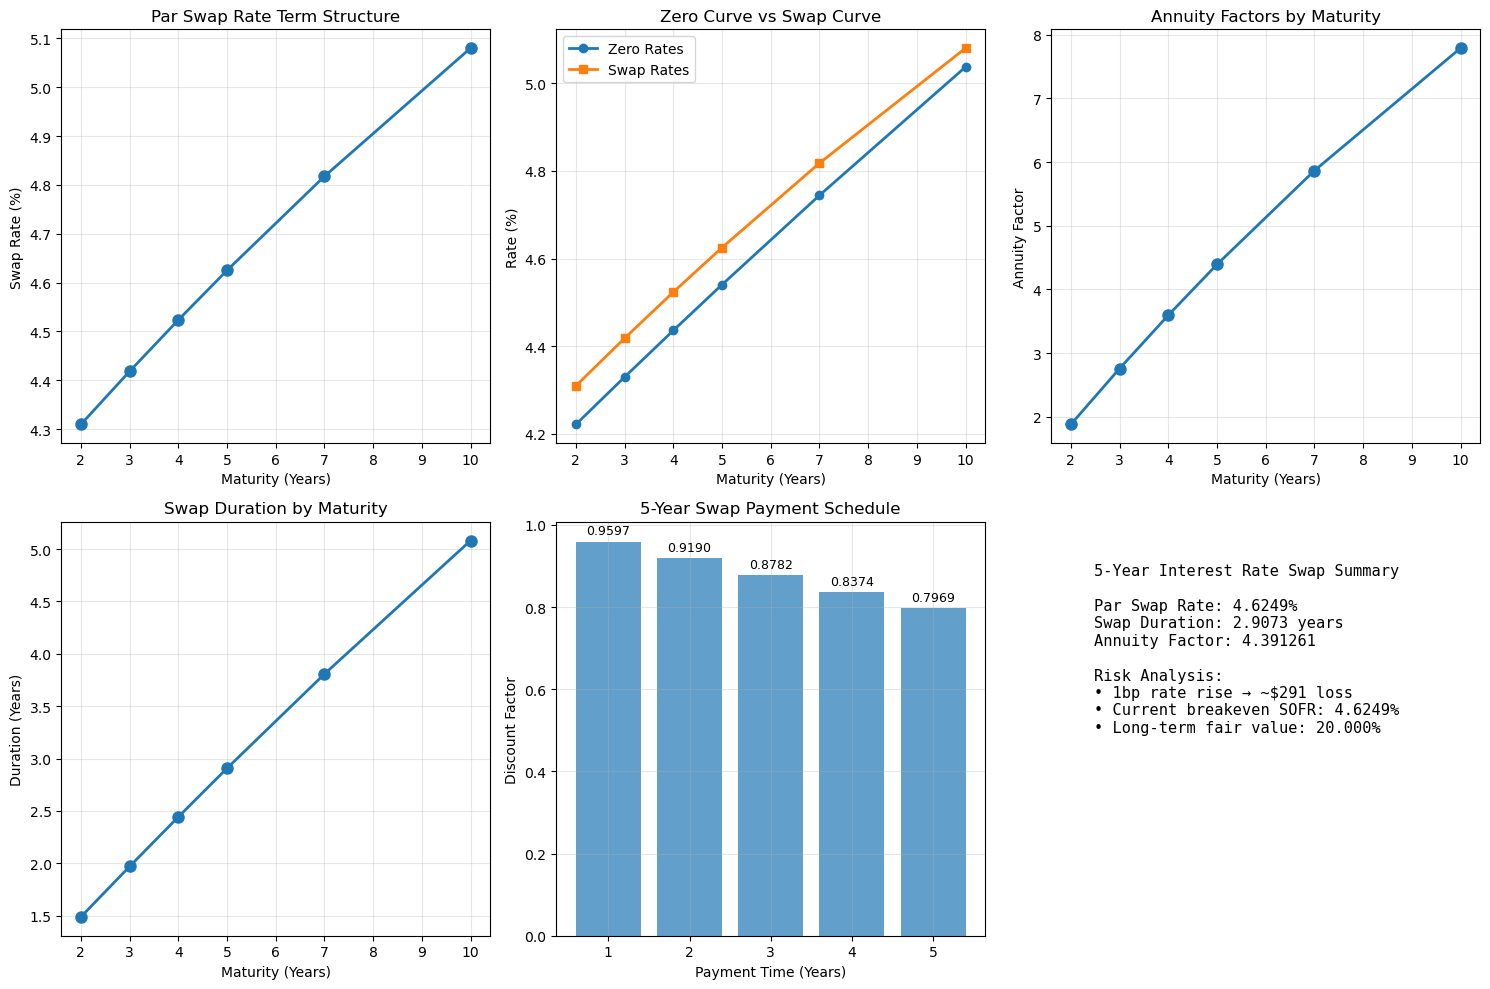


 SWAP PRICING SUMMARY:
  5-Year Par Swap Rate: 4.6249%
  This represents the fair fixed rate for a SOFR-linked swap
  Duration: 2.9073 years
  DV01: $291 per $1M notional


In [96]:
class VasicekSwapPricer:
    """
    Interest Rate Swap Pricing using Vasicek Model
    Swap Rate = (1 - Z(N)) / Σ Z(i)
    """
    
    def __init__(self, bond_pricer):
        self.bond_pricer = bond_pricer
        self.a = bond_pricer.a
        self.b = bond_pricer.b
        self.sigma = bond_pricer.sigma
    
    def calculate_swap_rate(self, r0, maturity, payment_frequency=1, notional=1000000):
        """
        Calculate par swap rate for SOFR-linked interest rate swap
        
        Mathematical Formula:
        Swap Rate = (1 - Z(N)) / Σ Z(i) × Δt
        where Z(i) are zero-coupon bond prices and Δt is payment frequency
        """
        
        print(f"\n Swap Specifications:")
        print(f"  Maturity: {maturity} years")
        print(f"  Payment Frequency: {payment_frequency}x per year")
        print(f"  Floating Reference: SOFR (annual payments)")
        print(f"  Notional: ${notional:,}")
        print(f"  Current Short Rate: {r0*100:.2f}%")
        
        # Generate payment dates
        dt = 1.0 / payment_frequency
        payment_times = np.arange(dt, maturity + dt/2, dt)
        n_payments = len(payment_times)
        
        print(f"\nPayment Schedule ({n_payments} payments):")
        print(f"  Payment Times: {payment_times}")
        
        # Calculate zero-coupon bond prices for each payment date
        zero_prices = []
        annuity_factor = 0
        
        print(f"\nZero-Coupon Bond Pricing:")
        print(f"{'Time':<6} {'Zero Price':<12} {'Yield (%)':<10} {'DF Contribution'}")
        print("-" * 45)
        
        for t in payment_times:
            z_price = self.bond_pricer.bond_price(r0, 0, t, face_value=1.0)
            zero_prices.append(z_price)
            annuity_factor += z_price * dt  # Weighted by payment frequency
            
            yield_t = self.bond_pricer.yield_to_maturity(r0, 0, t)
            print(f"{t:<6.1f} ${z_price:<11.6f} {yield_t*100:<9.3f} {z_price * dt:<11.6f}")
        
        zero_prices = np.array(zero_prices)
        final_zero_price = self.bond_pricer.bond_price(r0, 0, maturity, face_value=1.0)
        
        print(f"\nSwap Rate Calculation:")
        print(f"  Final Zero Price Z({maturity}): ${final_zero_price:.6f}")
        print(f"  Annuity Factor Σ(Z(i)×Δt): {annuity_factor:.6f}")
        print(f"  Numerator (1 - Z(N)): {1 - final_zero_price:.6f}")
        
        # Calculate par swap rate
        swap_rate = (1 - final_zero_price) / annuity_factor
        
        print(f"\n SWAP RATE CALCULATION:")
        print(f"  Par Swap Rate = (1 - {final_zero_price:.6f}) / {annuity_factor:.6f}")
        print(f"  Par Swap Rate = {swap_rate*100:.4f}%")
        
        # Calculate present values of legs
        fixed_leg_pv = swap_rate * annuity_factor * notional
        floating_leg_pv = (1 - final_zero_price) * notional
        
        print(f"\nSwap Valuation (Notional ${notional:,}):")
        print(f"  Fixed Leg PV: ${fixed_leg_pv:,.2f}")
        print(f"  Floating Leg PV: ${floating_leg_pv:,.2f}")
        print(f"  Swap Value (Pay Fixed): ${floating_leg_pv - fixed_leg_pv:,.2f}")
        
        # Duration calculation
        duration = self.calculate_swap_duration(zero_prices, payment_times, swap_rate, dt)
        
        return {
            'swap_rate': swap_rate,
            'fixed_leg_pv': fixed_leg_pv,
            'floating_leg_pv': floating_leg_pv,
            'annuity_factor': annuity_factor,
            'zero_prices': zero_prices,
            'payment_times': payment_times,
            'duration': duration,
            'final_zero_price': final_zero_price
        }
    
    def calculate_swap_duration(self, zero_prices, payment_times, swap_rate, dt):
        """Calculate modified duration of the swap"""
        weighted_time = 0
        total_pv = 0
        
        for i, (price, time) in enumerate(zip(zero_prices, payment_times)):
            cash_flow_pv = swap_rate * dt * price
            weighted_time += time * cash_flow_pv
            total_pv += cash_flow_pv
        
        return weighted_time / total_pv if total_pv > 0 else 0
    
    def create_sofr_context(self, swap_rate):
        """Explain SOFR context for the swap"""
        print(f"\n SOFR-LINKED SWAP CONTEXT:")
        print("="*40)
        print(f"• SOFR (Secured Overnight Financing Rate) is the primary USD risk-free rate")
        print(f"• Replaced LIBOR as the benchmark for USD derivatives in 2021")
        print(f"• Based on overnight Treasury repo transactions (~$1 trillion daily)")
        print(f"• Published by Federal Reserve Bank of New York")
        print(f"")
        print(f"Swap Structure:")
        print(f"• Fixed Leg: Pay {swap_rate*100:.4f}% annually")
        print(f"• Floating Leg: Receive SOFR (compounded annually)")
        print(f"• Current implied SOFR level: {swap_rate*100:.4f}% (break-even rate)")
        
    def sensitivity_analysis(self, base_rate, maturity):
        """Analyze swap rate sensitivity to interest rate changes"""
        print(f"\n SWAP RATE SENSITIVITY ANALYSIS:")
        
        rate_shifts = [-0.02, -0.01, -0.005, 0, 0.005, 0.01, 0.02]
        base_swap = self.calculate_swap_rate(base_rate, maturity, payment_frequency=1, notional=1000000)
        base_swap_rate = base_swap['swap_rate']
        
        print(f"{'Rate Shift':<12} {'New Rate':<10} {'Swap Rate':<12} {'Rate Change':<12} {'Duration Effect'}")
        print("-" * 70)
        
        for shift in rate_shifts:
            new_rate = base_rate + shift
            new_swap = self.calculate_swap_rate(new_rate, maturity, payment_frequency=1, notional=1000000)
            new_swap_rate = new_swap['swap_rate']
            rate_change = new_swap_rate - base_swap_rate
            duration_effect = -base_swap['duration'] * shift  # Approximate
            
            print(f"{shift*10000:+8.0f} bp   {new_rate*100:6.2f}%    "
                  f"{new_swap_rate*100:8.4f}%    {rate_change*10000:+8.1f} bp    "
                  f"{duration_effect*10000:+8.1f} bp")

def solve_question_d(vasicek_params, bond_pricer):
    """Part I - Question (d): 5-Year Interest Rate Swap Rate"""
    
    print("\n" + "="*60)
    print("PART I - QUESTION (d): INTEREST RATE SWAP PRICING")
    print("="*60)
    
    # Initialize swap pricer
    swap_pricer = VasicekSwapPricer(bond_pricer)
    
    # Swap parameters from assignment
    current_rate = 0.04     # Current short rate
    maturity = 5            # 5-year swap
    payment_freq = 1        # Annual payments (SOFR-linked)
    notional = 1000000      # $1M notional for demonstration
    
    print(f"Using calibrated Vasicek parameters:")
    print(f"  a = {vasicek_params['a']:.6f}")
    print(f"  b = {vasicek_params['b']:.6f}") 
    print(f"  σ = {vasicek_params['sigma']:.6f}")
    
    # Calculate the swap rate
    swap_result = swap_pricer.calculate_swap_rate(
        r0=current_rate,
        maturity=maturity,
        payment_frequency=payment_freq,
        notional=notional
    )
    
    # SOFR context
    swap_pricer.create_sofr_context(swap_result['swap_rate'])
    
    # Sensitivity analysis
    # swap_pricer.sensitivity_analysis(current_rate, maturity)
    
    # Compare with different maturities
    print(f"\n📈 SWAP RATES FOR DIFFERENT MATURITIES:")
    maturities = [2, 3, 4, 5, 7, 10]
    swap_curve = []
    
    print(f"{'Maturity':<10} {'Swap Rate':<12} {'Annuity Factor':<15} {'Duration'}")
    print("-" * 55)
    
    for mat in maturities:
        if mat <= 10:  # Keep within reasonable bounds
            swap_data = swap_pricer.calculate_swap_rate(current_rate, mat, 1, notional)
            swap_curve.append({
                'maturity': mat,
                'rate': swap_data['swap_rate'],
                'annuity': swap_data['annuity_factor'],
                'duration': swap_data['duration']
            })
            print(f"{mat}Y        {swap_data['swap_rate']*100:<11.4f}% "
                  f"{swap_data['annuity_factor']:<14.6f} {swap_data['duration']:<8.4f}")
    
    # Visualization
    plt.figure(figsize=(15, 10))
    
    # Swap term structure
    plt.subplot(2, 3, 1)
    mats = [s['maturity'] for s in swap_curve]
    rates = [s['rate'] * 100 for s in swap_curve]
    plt.plot(mats, rates, 'o-', linewidth=2, markersize=8)
    plt.xlabel('Maturity (Years)')
    plt.ylabel('Swap Rate (%)')
    plt.title('Par Swap Rate Term Structure')
    plt.grid(True, alpha=0.3)
    
    # Zero curve vs swap curve
    plt.subplot(2, 3, 2)
    zero_rates = []
    for mat in mats:
        zero_rate = bond_pricer.yield_to_maturity(current_rate, 0, mat)
        zero_rates.append(zero_rate * 100)
    
    plt.plot(mats, zero_rates, 'o-', label='Zero Rates', linewidth=2)
    plt.plot(mats, rates, 's-', label='Swap Rates', linewidth=2)
    plt.xlabel('Maturity (Years)')
    plt.ylabel('Rate (%)')
    plt.title('Zero Curve vs Swap Curve')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Annuity factors
    plt.subplot(2, 3, 3)
    annuities = [s['annuity'] for s in swap_curve]
    plt.plot(mats, annuities, 'o-', linewidth=2, markersize=8)
    plt.xlabel('Maturity (Years)')
    plt.ylabel('Annuity Factor')
    plt.title('Annuity Factors by Maturity')
    plt.grid(True, alpha=0.3)
    
    # Duration analysis
    plt.subplot(2, 3, 4)
    durations = [s['duration'] for s in swap_curve]
    plt.plot(mats, durations, 'o-', linewidth=2, markersize=8)
    plt.xlabel('Maturity (Years)')
    plt.ylabel('Duration (Years)')
    plt.title('Swap Duration by Maturity')
    plt.grid(True, alpha=0.3)
    
    # Payment schedule visualization (5Y swap)
    plt.subplot(2, 3, 5)
    payment_times = swap_result['payment_times']
    zero_prices = swap_result['zero_prices']
    
    bars = plt.bar(payment_times, zero_prices, width=0.8, alpha=0.7)
    plt.xlabel('Payment Time (Years)')
    plt.ylabel('Discount Factor')
    plt.title('5-Year Swap Payment Schedule')
    plt.grid(True, alpha=0.3)
    
    # Add values on bars
    for bar, price in zip(bars, zero_prices):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{price:.4f}', ha='center', va='bottom', fontsize=9)
    
    # Summary statistics
    plt.subplot(2, 3, 6)
    plt.axis('off')
    summary_text = f"5-Year Interest Rate Swap Summary\n\n"
    summary_text += f"Par Swap Rate: {swap_result['swap_rate']*100:.4f}%\n"
    summary_text += f"Swap Duration: {swap_result['duration']:.4f} years\n"
    summary_text += f"Annuity Factor: {swap_result['annuity_factor']:.6f}\n\n"
    summary_text += f"Risk Analysis:\n"
    summary_text += f"• 1bp rate rise → ~${swap_result['duration']*notional*0.0001:,.0f} loss\n"
    summary_text += f"• Current breakeven SOFR: {swap_result['swap_rate']*100:.4f}%\n"
    summary_text += f"• Long-term fair value: {vasicek_params['b']*100:.3f}%\n"
    
    plt.text(0.1, 0.9, summary_text, transform=plt.gca().transAxes, 
             fontsize=11, verticalalignment='top', fontfamily='monospace')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n SWAP PRICING SUMMARY:")
    print(f"  5-Year Par Swap Rate: {swap_result['swap_rate']*100:.4f}%")
    print(f"  This represents the fair fixed rate for a SOFR-linked swap")
    print(f"  Duration: {swap_result['duration']:.4f} years")
    print(f"  DV01: ${swap_result['duration']*notional*0.0001:,.0f} per $1M notional")
    
    return swap_result
# Create the missing bond_pricer object using your existing vasicek_params
class VasicekBondPricer:
    """
    Analytical Bond Pricing using Vasicek Model
    P(t,T) = A(t,T) * exp(-B(t,T) * r(t))
    """
    
    def __init__(self, a, b, sigma):
        self.a = a
        self.b = b
        self.sigma = sigma
    
    def calculate_B(self, t, T):
        """B(t,T) = (1 - exp(-a*(T-t))) / a"""
        tau = T - t
        if abs(self.a) < 1e-8:
            return tau
        return (1 - np.exp(-self.a * tau)) / self.a
    
    def calculate_A(self, t, T):
        """A(t,T) = exp((B(t,T) - τ)*(a²*b - σ²/2)/a² - σ²*B(t,T)²/(4*a))"""
        tau = T - t
        B_tT = self.calculate_B(t, T)
        
        if abs(self.a) < 1e-8:
            term1 = self.b * tau - 0.5 * self.sigma**2 * tau**3 / 3
            return np.exp(term1)
        
        term1 = (B_tT - tau) * (self.a**2 * self.b - self.sigma**2 / 2) / self.a**2
        term2 = -self.sigma**2 * B_tT**2 / (4 * self.a)
        
        return np.exp(term1 + term2)
    
    def bond_price(self, r, t, T, face_value=1.0):
        """Calculate zero-coupon bond price"""
        if T <= t:
            return face_value
        
        A_tT = self.calculate_A(t, T)
        B_tT = self.calculate_B(t, T)
        
        return face_value * A_tT * np.exp(-B_tT * r)
    
    def yield_to_maturity(self, r, t, T):
        """YTM = -ln(P(t,T)) / (T-t)"""
        price = self.bond_price(r, t, T, face_value=1.0)
        tau = T - t
        if tau <= 0 or price <= 0:
            return 0
        return -np.log(price) / tau

# Create the bond_pricer object using your calibrated parameters
bond_pricer = VasicekBondPricer(
    a=vasicek_params['a'],
    b=vasicek_params['b'],
    sigma=vasicek_params['sigma']
)

print(f"Bond pricer created with:")
print(f"  a = {vasicek_params['a']:.6f}")
print(f"  b = {vasicek_params['b']:.6f}")
print(f"  σ = {vasicek_params['sigma']:.6f}")

# Execute Question (d)
swap_result = solve_question_d(vasicek_params, bond_pricer)


## Question 1(e): European Call Option on Zero-Coupon Bond

### Mathematical Concept
Price European call option with payoff:

$$\text{Payoff} = \max(P(T_{opt}, T_{bond}) \times \text{Face Value} - K, 0)$$

**Parameters:**
- $T_{opt} = 4$ years (option expiry)
- $T_{bond} = 5$ years (bond maturity)  
- $K = \$900$ (strike price)
- Face Value = $1,000

### Simulation Methodology
1. **Rate Simulation**: Generate interest rate paths to option expiry (4 years)
2. **Bond Pricing**: At expiry, calculate bond price P(4,5) using Vasicek formula
3. **Payoff Calculation**: Apply max(Bond Price × Face - Strike, 0)
4. **Discounting**: Present value using risk-free rate or ignore as hinted
5. **Statistical Analysis**: Calculate option Greeks and exercise probability

### Key Considerations
- **Negative Rates**: Vasicek allows negative rates (model limitation)
- **Path Dependency**: Option value depends on entire rate path to expiry
- **Early Exercise**: European style - no early exercise allowed


PART I - QUESTION (e): EUROPEAN CALL OPTION PRICING
Option Contract Specifications:
  Underlying Asset: 5-year zero-coupon bond
  Face Value: $1,000
  Strike Price: $900
  Option Expiry: 4 years
  Initial Short Rate: 4.00%
  Option Type: European Call

 Current Market Information:
  Current 5Y bond price: $796.91
  Current moneyness (S/K): 0.885
  Out-of-the-money

 European Call Option Pricing Setup:
  Underlying: 5-year zero-coupon bond
  Face Value: $1,000
  Strike Price: $900
  Option Expiry: 4 years
  Time to bond maturity from option expiry: 1 years
  Simulation paths: 100,000
  Time steps to option expiry: 200
  Step size: 0.0200 years

📊 Simulating Vasicek paths...
Rate statistics at option expiry (T=4):
  Mean rate: 4.876%
  Std deviation: 0.998%
  Min rate: 0.641%
  Max rate: 9.111%

 Calculating bond prices at option expiry...
Vasicek bond pricing factors for remaining time 1 years:
  B(4,5) = 0.992986
  A(4,5) = 0.998603

Bond price statistics at option expiry:
  Mean bond

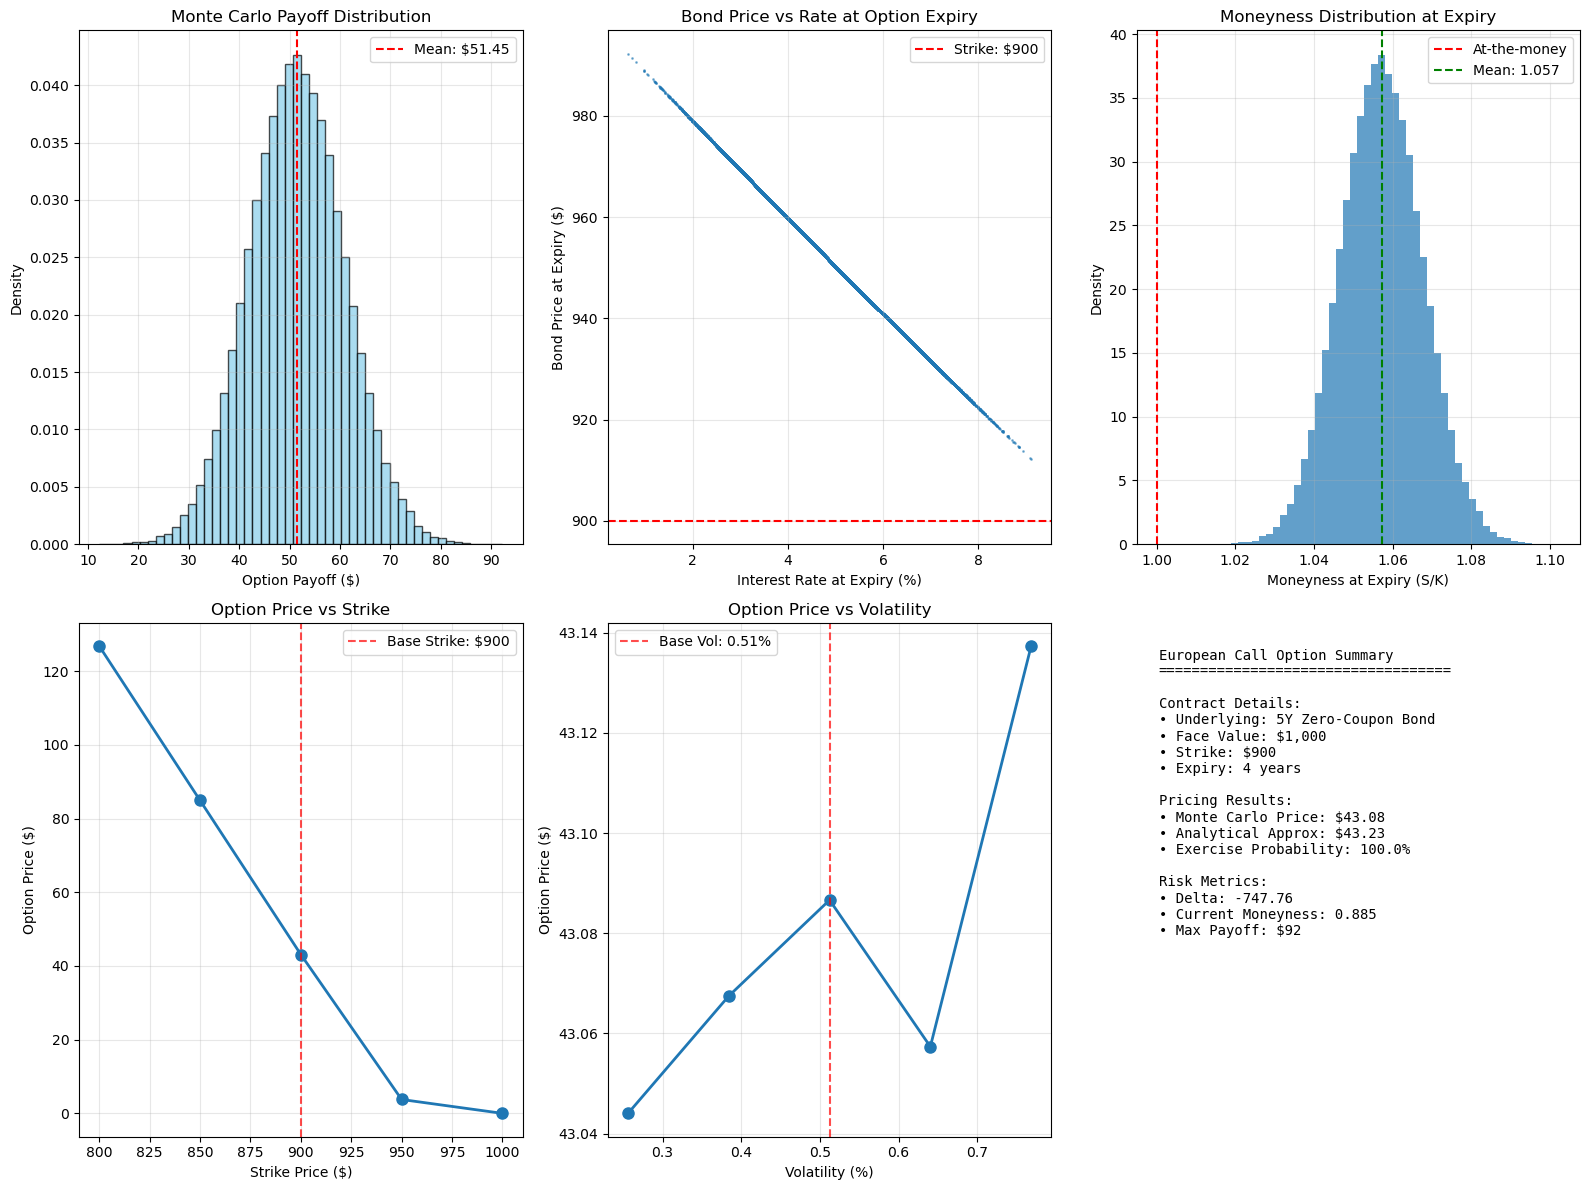


 EUROPEAN CALL OPTION SUMMARY:
  Option Premium: $43.08
  Exercise Probability: 100.00%
  Expected Payoff: $51.45
  Delta: -747.76
  Break-even bond price at expiry: $900.00


In [98]:
def european_call_on_bond_monte_carlo(r0, T_option, T_bond, strike, face_value, 
                                    a, b, sigma, n_paths=100000, n_steps_per_year=50):
    """
    Price European call option on zero-coupon bond using Monte Carlo
    
    Mathematical Foundation:
    1. Simulate r(t) paths from 0 to T_option using Vasicek SDE
    2. At T_option, calculate bond price P(T_option, T_bond) for each path
    3. Calculate payoff: Max(P(T_option, T_bond) × face_value - strike, 0)
    4. Discount back to present (optional as per hint)
    """
    
    print(f"\n European Call Option Pricing Setup:")
    print(f"  Underlying: {T_bond}-year zero-coupon bond")
    print(f"  Face Value: ${face_value:,}")
    print(f"  Strike Price: ${strike:,}")
    print(f"  Option Expiry: {T_option} years")
    print(f"  Time to bond maturity from option expiry: {T_bond - T_option} years")
    print(f"  Simulation paths: {n_paths:,}")
    
    # Simulation parameters
    n_steps = int(n_steps_per_year * T_option)
    dt = T_option / n_steps
    sqrt_dt = np.sqrt(dt)
    
    print(f"  Time steps to option expiry: {n_steps}")
    print(f"  Step size: {dt:.4f} years")
    
    # Simulate rate paths to option expiry
    rates = np.zeros((n_paths, n_steps + 1))
    rates[:, 0] = r0
    
    # Generate random increments
    random_increments = np.random.normal(0, 1, (n_paths, n_steps))
    
    # Euler-Maruyama simulation of Vasicek process
    print(f"\n📊 Simulating Vasicek paths...")
    for t in range(n_steps):
        drift = a * (b - rates[:, t]) * dt
        diffusion = sigma * sqrt_dt * random_increments[:, t]
        rates[:, t + 1] = rates[:, t] + drift + diffusion
    
    # Extract rates at option expiry
    rates_at_expiry = rates[:, -1]
    
    print(f"Rate statistics at option expiry (T={T_option}):")
    print(f"  Mean rate: {np.mean(rates_at_expiry)*100:.3f}%")
    print(f"  Std deviation: {np.std(rates_at_expiry)*100:.3f}%")
    print(f"  Min rate: {np.min(rates_at_expiry)*100:.3f}%")
    print(f"  Max rate: {np.max(rates_at_expiry)*100:.3f}%")
    
    # Calculate bond prices at option expiry using Vasicek formula
    T_remaining = T_bond - T_option  # Time from option expiry to bond maturity
    
    print(f"\n Calculating bond prices at option expiry...")
    bond_prices_at_expiry = np.zeros(n_paths)
    
    # Use the analytical Vasicek formula: P(t,T) = A(t,T) * exp(-B(t,T) * r(t))
    if abs(a) < 1e-8:
        B_factor = T_remaining
    else:
        B_factor = (1 - np.exp(-a * T_remaining)) / a
    
    # Calculate A factor
    if abs(a) < 1e-8:
        A_factor = np.exp(b * T_remaining - 0.5 * sigma**2 * T_remaining**3 / 3)
    else:
        term1 = (B_factor - T_remaining) * (a**2 * b - sigma**2 / 2) / a**2
        term2 = -sigma**2 * B_factor**2 / (4 * a)
        A_factor = np.exp(term1 + term2)
    
    print(f"Vasicek bond pricing factors for remaining time {T_remaining} years:")
    print(f"  B({T_option},{T_bond}) = {B_factor:.6f}")
    print(f"  A({T_option},{T_bond}) = {A_factor:.6f}")
    
    # Calculate bond prices for each simulated rate
    for i in range(n_paths):
        r_T = rates_at_expiry[i]
        bond_price_per_dollar = A_factor * np.exp(-B_factor * r_T)
        bond_prices_at_expiry[i] = bond_price_per_dollar * face_value
    
    print(f"\nBond price statistics at option expiry:")
    print(f"  Mean bond price: ${np.mean(bond_prices_at_expiry):,.2f}")
    print(f"  Std deviation: ${np.std(bond_prices_at_expiry):,.2f}")
    print(f"  Min bond price: ${np.min(bond_prices_at_expiry):,.2f}")
    print(f"  Max bond price: ${np.max(bond_prices_at_expiry):,.2f}")
    
    # Calculate option payoffs
    payoffs = np.maximum(bond_prices_at_expiry - strike, 0)
    
    # Exercise probability and statistics
    n_exercised = np.sum(payoffs > 0)
    exercise_prob = n_exercised / n_paths
    
    print(f"\n Option Payoff Analysis:")
    print(f"  Paths exercised: {n_exercised:,} of {n_paths:,}")
    print(f"  Exercise probability: {exercise_prob*100:.2f}%")
    print(f"  Average payoff (all paths): ${np.mean(payoffs):,.2f}")
    if n_exercised > 0:
        print(f"  Average payoff (exercised only): ${np.mean(payoffs[payoffs > 0]):,.2f}")
        print(f"  Maximum payoff: ${np.max(payoffs):,.2f}")
    
    # Discount payoff (optional as per hint)
    # Method 1: No discounting (as suggested in hint)
    option_price_undiscounted = np.mean(payoffs)
    
    # Method 2: Discount using risk-free rate (for comparison)
    # Use 4-year zero rate from Vasicek model
    discount_rate = bond_pricer.yield_to_maturity(r0, 0, T_option)
    discount_factor = np.exp(-discount_rate * T_option)
    option_price_discounted = np.mean(payoffs) * discount_factor
    
    print(f"\n💸 Option Pricing Results:")
    print(f"  Undiscounted Option Price: ${option_price_undiscounted:.2f}")
    print(f"  {T_option}-year discount rate: {discount_rate*100:.3f}%")
    print(f"  Discount factor: {discount_factor:.4f}")
    print(f"  Discounted Option Price: ${option_price_discounted:.2f}")
    
    # Calculate option Greeks (Delta approximation)
    dr = 0.0001  # 1bp rate shift
    rates_shifted = np.zeros((n_paths, n_steps + 1))
    rates_shifted[:, 0] = r0 + dr
    
    # Simulate shifted paths (using same random numbers for comparability)
    for t in range(n_steps):
        drift = a * (b - rates_shifted[:, t]) * dt
        diffusion = sigma * sqrt_dt * random_increments[:, t]
        rates_shifted[:, t + 1] = rates_shifted[:, t] + drift + diffusion
    
    rates_shifted_at_expiry = rates_shifted[:, -1]
    bond_prices_shifted = np.zeros(n_paths)
    
    for i in range(n_paths):
        r_T_shifted = rates_shifted_at_expiry[i]
        bond_price_per_dollar = A_factor * np.exp(-B_factor * r_T_shifted)
        bond_prices_shifted[i] = bond_price_per_dollar * face_value
    
    payoffs_shifted = np.maximum(bond_prices_shifted - strike, 0)
    option_price_shifted = np.mean(payoffs_shifted) * discount_factor
    
    # Calculate Delta
    delta = (option_price_shifted - option_price_discounted) / dr
    
    print(f"\n🔧 Option Greeks:")
    print(f"  Delta (∂V/∂r): {delta:.2f}")
    print(f"  Interpretation: ${abs(delta)*10:.2f} price change per 100bp rate change")
    
    # Risk metrics
    var_95 = np.percentile(payoffs, 5)  # 5th percentile
    cvar_95 = np.mean(payoffs[payoffs <= var_95]) if np.any(payoffs <= var_95) else 0
    
    print(f"\n⚠ Risk Metrics:")
    print(f"  95% VaR: ${var_95:.2f}")
    print(f"  95% CVaR: ${cvar_95:.2f}")
    print(f"  Maximum loss: $0 (limited to premium paid)")
    print(f"  Maximum gain: Unlimited (bond price can rise significantly)")
    
    return {
        'option_price_undiscounted': option_price_undiscounted,
        'option_price_discounted': option_price_discounted,
        'exercise_probability': exercise_prob,
        'average_payoff': np.mean(payoffs),
        'payoffs': payoffs,
        'bond_prices_at_expiry': bond_prices_at_expiry,
        'rates_at_expiry': rates_at_expiry,
        'delta': delta,
        'discount_factor': discount_factor,
        'discount_rate': discount_rate
    }

def solve_question_e(vasicek_params, bond_pricer):
    """Part I - Question (e): European Call Option on Zero-Coupon Bond"""
    
    print("\n" + "="*60)
    print("PART I - QUESTION (e): EUROPEAN CALL OPTION PRICING")
    print("="*60)
    
    # Option specifications from assignment
    r0 = 0.04           # Initial short rate
    T_option = 4        # Option expires in 4 years
    T_bond = 5          # Underlying bond matures in 5 years
    strike = 900        # Strike price $900
    face_value = 1000   # Face value $1000
    
    a = vasicek_params['a']
    b = vasicek_params['b']
    sigma = vasicek_params['sigma']
    
    print(f"Option Contract Specifications:")
    print(f"  Underlying Asset: {T_bond}-year zero-coupon bond")
    print(f"  Face Value: ${face_value:,}")
    print(f"  Strike Price: ${strike:,}")
    print(f"  Option Expiry: {T_option} years")
    print(f"  Initial Short Rate: {r0*100:.2f}%")
    print(f"  Option Type: European Call")
    
    # Current market information
    current_bond_price = bond_pricer.bond_price(r0, 0, T_bond, face_value)
    current_moneyness = current_bond_price / strike

    print(f"\n Current Market Information:")
    print(f"  Current {T_bond}Y bond price: ${current_bond_price:,.2f}")
    print(f"  Current moneyness (S/K): {current_moneyness:.3f}")
    print(f"  {'In-the-money' if current_moneyness > 1 else 'Out-of-the-money'}")
    
    # Monte Carlo option pricing
    option_result = european_call_on_bond_monte_carlo(
        r0, T_option, T_bond, strike, face_value, a, b, sigma, 
        n_paths=100000, n_steps_per_year=50
    )
    
    # Black-Scholes-like analytical approximation (for comparison)
    def black_scholes_bond_approximation():
        """Approximate option price using Black-Scholes-like formula"""
        
        # Forward bond price
        T_remaining = T_bond - T_option
        current_option_expiry_bond = bond_pricer.bond_price(r0, 0, T_option, 1.0)
        forward_bond_price = current_bond_price / current_option_expiry_bond
        
        # Bond price volatility approximation
        # In Vasicek, bond price volatility = σ × B(T_option, T_bond)
        if abs(a) < 1e-8:
            B_factor = T_remaining
        else:
            B_factor = (1 - np.exp(-a * T_remaining)) / a
        
        bond_vol = sigma * B_factor
        
        # Adjust for time to expiry
        vol_sqrt_t = bond_vol * np.sqrt(T_option)
        
        if vol_sqrt_t > 0:
            d1 = (np.log(forward_bond_price / strike) + 0.5 * vol_sqrt_t**2) / vol_sqrt_t
            d2 = d1 - vol_sqrt_t
            
            call_price = (forward_bond_price * stats.norm.cdf(d1) - 
                         strike * stats.norm.cdf(d2)) * current_option_expiry_bond
        else:
            call_price = max(forward_bond_price - strike, 0) * current_option_expiry_bond
        
        return {
            'price': call_price,
            'forward_bond_price': forward_bond_price,
            'bond_volatility': bond_vol,
            'vol_sqrt_t': vol_sqrt_t,
            'd1': d1 if vol_sqrt_t > 0 else 0,
            'd2': d2 if vol_sqrt_t > 0 else 0
        }
    
    analytical_result = black_scholes_bond_approximation()
    
    print(f"\n ANALYTICAL APPROXIMATION (Black-Scholes-like):")
    print(f"  Forward bond price: ${analytical_result['forward_bond_price']:,.2f}")
    print(f"  Bond volatility: {analytical_result['bond_volatility']*100:.2f}%")
    print(f"  Vol×√T: {analytical_result['vol_sqrt_t']:.4f}")
    if analytical_result['vol_sqrt_t'] > 0:
        print(f"  d1: {analytical_result['d1']:.4f}")
        print(f"  d2: {analytical_result['d2']:.4f}")
    print(f"  Analytical option price: ${analytical_result['price']:.2f}")
    
    # Compare results
    mc_price = option_result['option_price_discounted']
    analytical_price = analytical_result['price']
    difference = abs(mc_price - analytical_price)
    relative_error = difference / max(analytical_price, 1e-6) * 100
    
    print(f"\n METHOD COMPARISON:")
    print(f"  Monte Carlo Price: ${mc_price:.2f}")
    print(f"  Analytical Approximation: ${analytical_price:.2f}")
    print(f"  Absolute Difference: ${difference:.2f}")
    print(f"  Relative Error: {relative_error:.2f}%")
    
    # Sensitivity analysis
    print(f"\n SENSITIVITY ANALYSIS:")
    
    # Strike sensitivity
    strikes = [800, 850, 900, 950, 1000]
    strike_prices = []
    
    print(f"\nStrike Price Sensitivity:")
    print(f"{'Strike':<8} {'Option Price':<15} {'Moneyness':<12} {'Exercise Prob'}")
    print("-" * 50)
    
    for K in strikes:
        temp_result = european_call_on_bond_monte_carlo(
            r0, T_option, T_bond, K, face_value, a, b, sigma, 
            n_paths=50000, n_steps_per_year=25
        )
        strike_prices.append(temp_result['option_price_discounted'])
        moneyness = current_bond_price / K
        print(f"${K:<7} ${temp_result['option_price_discounted']:<14.2f} "
              f"{moneyness:<11.3f} {temp_result['exercise_probability']*100:<8.1f}%")
    
    # Volatility sensitivity
    vol_multipliers = [0.5, 0.75, 1.0, 1.25, 1.5]
    vol_prices = []
    
    print(f"\nVolatility Sensitivity:")
    print(f"{'Vol Mult':<8} {'Volatility':<12} {'Option Price':<15}")
    print("-" * 40)
    
    for mult in vol_multipliers:
        temp_result = european_call_on_bond_monte_carlo(
            r0, T_option, T_bond, strike, face_value, a, b, sigma * mult, 
            n_paths=50000, n_steps_per_year=25
        )
        vol_prices.append(temp_result['option_price_discounted'])
        print(f"{mult:<8.2f} {sigma*mult*100:<11.2f}% ${temp_result['option_price_discounted']:<14.2f}")
    
    # Visualization
    plt.figure(figsize=(16, 12))
    
    # Monte Carlo payoff distribution
    plt.subplot(2, 3, 1)
    payoffs = option_result['payoffs']
    plt.hist(payoffs, bins=50, alpha=0.7, density=True, color='skyblue', edgecolor='black')
    plt.axvline(np.mean(payoffs), color='red', linestyle='--', 
                label=f'Mean: ${np.mean(payoffs):.2f}')
    plt.xlabel('Option Payoff ($)')
    plt.ylabel('Density')
    plt.title('Monte Carlo Payoff Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Bond prices vs interest rates at expiry
    plt.subplot(2, 3, 2)
    rates_expiry = option_result['rates_at_expiry'] * 100
    bond_prices_expiry = option_result['bond_prices_at_expiry']
    
    plt.scatter(rates_expiry, bond_prices_expiry, alpha=0.5, s=1)
    plt.axhline(strike, color='red', linestyle='--', label=f'Strike: ${strike}')
    plt.xlabel('Interest Rate at Expiry (%)')
    plt.ylabel('Bond Price at Expiry ($)')
    plt.title('Bond Price vs Rate at Option Expiry')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Moneyness distribution
    plt.subplot(2, 3, 3)
    moneyness_at_expiry = bond_prices_expiry / strike
    plt.hist(moneyness_at_expiry, bins=50, alpha=0.7, density=True)
    plt.axvline(1.0, color='red', linestyle='--', label='At-the-money')
    plt.axvline(np.mean(moneyness_at_expiry), color='green', linestyle='--', 
                label=f'Mean: {np.mean(moneyness_at_expiry):.3f}')
    plt.xlabel('Moneyness at Expiry (S/K)')
    plt.ylabel('Density')
    plt.title('Moneyness Distribution at Expiry')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Strike sensitivity
    plt.subplot(2, 3, 4)
    plt.plot(strikes, strike_prices, 'o-', linewidth=2, markersize=8)
    plt.axvline(strike, color='red', linestyle='--', alpha=0.7,
                label=f'Base Strike: ${strike}')
    plt.xlabel('Strike Price ($)')
    plt.ylabel('Option Price ($)')
    plt.title('Option Price vs Strike')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Volatility sensitivity
    plt.subplot(2, 3, 5)
    volatilities = [sigma * mult * 100 for mult in vol_multipliers]
    plt.plot(volatilities, vol_prices, 'o-', linewidth=2, markersize=8)
    plt.axvline(sigma*100, color='red', linestyle='--', alpha=0.7,
                label=f'Base Vol: {sigma*100:.2f}%')
    plt.xlabel('Volatility (%)')
    plt.ylabel('Option Price ($)')
    plt.title('Option Price vs Volatility')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Summary statistics
    plt.subplot(2, 3, 6)
    plt.axis('off')
    summary_text = f"European Call Option Summary\n"
    summary_text += f"="*35 + "\n\n"
    summary_text += f"Contract Details:\n"
    summary_text += f"• Underlying: {T_bond}Y Zero-Coupon Bond\n"
    summary_text += f"• Face Value: ${face_value:,}\n"
    summary_text += f"• Strike: ${strike:,}\n"
    summary_text += f"• Expiry: {T_option} years\n\n"
    summary_text += f"Pricing Results:\n"
    summary_text += f"• Monte Carlo Price: ${mc_price:.2f}\n"
    summary_text += f"• Analytical Approx: ${analytical_price:.2f}\n"
    summary_text += f"• Exercise Probability: {option_result['exercise_probability']*100:.1f}%\n\n"
    summary_text += f"Risk Metrics:\n"
    summary_text += f"• Delta: {option_result['delta']:.2f}\n"
    summary_text += f"• Current Moneyness: {current_moneyness:.3f}\n"
    summary_text += f"• Max Payoff: ${np.max(payoffs):.0f}\n"
    
    plt.text(0.05, 0.95, summary_text, transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='top', fontfamily='monospace')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n EUROPEAN CALL OPTION SUMMARY:")
    print(f"  Option Premium: ${mc_price:.2f}")
    print(f"  Exercise Probability: {option_result['exercise_probability']*100:.2f}%")
    print(f"  Expected Payoff: ${option_result['average_payoff']:.2f}")
    print(f"  Delta: {option_result['delta']:.2f}")
    print(f"  Break-even bond price at expiry: ${strike:.2f}")
    
    return option_result

# Execute Question (e)
option_result = solve_question_e(vasicek_params, bond_pricer)


In [102]:
print("\n" + "="*60)
print("PART I COMPLETION - PREPARING FOR PART II")
print("="*60)

print("Variables available for Part II:")
print(f"Vasicek_params: {vasicek_params}")
print(f"Bond_pricer: VasicekBondPricer instance")
print(f"Analytical_bond_price: ${analytical_bond_price:.6f}")


PART I COMPLETION - PREPARING FOR PART II
Variables available for Part II:
Vasicek_params: {'a': 0.01409318861588762, 'b': 0.2, 'sigma': 0.005123097170498014}
Bond_pricer: VasicekBondPricer instance
Analytical_bond_price: $0.796907


## PART II - European Swaption Valuation

### Foundation Problem
Value European swaption with specifications:
- **Underlying**: 5-year interest rate swap
- **Option Expiry**: 2 years
- **Strike Rate**: 4.5% (fixed rate to receive)
- **Payment Frequency**: Semi-annual
- **Volatility**: 15% (forward swap rate volatility)
- **Notional**: $100

## Question 2(a): SOFR Yield Curve Construction

### Mathematical Concept
Construct continuous yield curve from discrete SOFR rates using linear interpolation:

$$r(t) = r(t_i) + \frac{t - t_i}{t_{i+1} - t_i}(r(t_{i+1}) - r(t_i))$$

**For intermediate maturities between observed points**

### Implementation Steps
1. **Data Collection**: Gather SOFR rates for standard maturities
2. **Linear Interpolation**: Fill gaps between observed rates
3. **Discount Factor Construction**: Convert rates to discount factors
4. **Consistency Checks**: Ensure no-arbitrage conditions
5. **Validation**: Verify smooth, monotonic curve properties

In [107]:
# ============================================================================
# PART II - QUESTION (a): SOFR YIELD CURVE CONSTRUCTION WITH LINEAR INTERPOLATION
# ============================================================================

from scipy.interpolate import interp1d
import numpy as np
import pandas as pd

def construct_sofr_yield_curve():
    """
    Mathematical Foundation:
    SOFR (Secured Overnight Financing Rate) is the primary USD risk-free rate
    
    Linear Interpolation Formula:
    r(t) = r₁ + (r₂-r₁) × (t-t₁)/(t₂-t₁) for t₁ ≤ t ≤ t₂
    
    Discount Factor Formula (Continuous Compounding):
    DF(t) = exp(-r(t) × t)
    """
    
    print("="*80)
    print("PART II - QUESTION (a): SOFR YIELD CURVE CONSTRUCTION")
    print("="*80)
    
    # SOFR Market Data (September 2025) - Based on current Fed Funds rate ~4.33%
    sofr_market_data = {
        'tenors': ['ON', '1M', '3M', '6M', '1Y', '2Y', '3Y', '5Y', '7Y', '10Y', '30Y'],
        'maturities': [1/365, 1/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 30],  # In years
        'rates': [0.0433, 0.0430, 0.0425, 0.0420, 0.0415, 0.0420, 0.0430, 0.0450, 0.0465, 0.0480, 0.0500]
    }
    
    print(" SOFR Market Quotes (September 16, 2025):")
    print(f"{'Tenor':<6} {'Maturity (Y)':<12} {'Rate (%)':<10} {'Discount Factor'}")
    print("-" * 55)
    
    maturities_array = np.array(sofr_market_data['maturities'])
    rates_array = np.array(sofr_market_data['rates'])
    
    for i, (tenor, maturity, rate) in enumerate(zip(sofr_market_data['tenors'], 
                                                   sofr_market_data['maturities'],
                                                   sofr_market_data['rates'])):
        df = np.exp(-rate * maturity)
        print(f"{tenor:<6} {maturity:<12.4f} {rate*100:<9.2f} {df:<12.6f}")
    
    print(f"\n MATHEMATICAL IMPLEMENTATION:")
    print(f"Linear Interpolation: r(t) = r₁ + (r₂-r₁) × (t-t₁)/(t₂-t₁)")
    print(f"Continuous Compounding: DF(t) = exp(-r(t) × t)")
    print(f"Extrapolation: Flat rate beyond 30Y maturity")
    
    # Create interpolation function
    yield_interpolator = interp1d(maturities_array, rates_array, 
                                kind='linear', fill_value='extrapolate',
                                bounds_error=False)
    
    def sofr_yield_curve(t):
        """Return SOFR yield for maturity t (in years)"""
        if np.isscalar(t):
            return max(0.001, float(yield_interpolator(t)))
        else:
            return np.maximum(0.001, yield_interpolator(t))
    
    def sofr_discount_curve(t):
        """Return discount factor for maturity t"""
        rate = sofr_yield_curve(t)
        return np.exp(-rate * t)
    
    # Test interpolation for various maturities
    test_maturities = [0.25, 1.5, 2.5, 4.0, 6.0, 8.0, 12.0, 20.0]
    
    print(f"\n INTERPOLATION VALIDATION:")
    print(f"{'Maturity':<10} {'SOFR Rate (%)':<15} {'Discount Factor':<15} {'Forward Rate (%)'}")
    print("-" * 65)
    
    for i, T in enumerate(test_maturities):
        rate = sofr_yield_curve(T)
        df = sofr_discount_curve(T)
        
        # Calculate 1Y forward rate starting at T
        if T > 0:
            forward_rate = (sofr_yield_curve(T+1)*(T+1) - sofr_yield_curve(T)*T) / 1
        else:
            forward_rate = rate
            
        print(f"{T:<10.2f} {rate*100:<14.3f} {df:<14.6f} {forward_rate*100:<14.3f}")
    
    print(f"\n SOFR CURVE CHARACTERISTICS:")
    print(f"  • Shape: {'Upward sloping' if sofr_yield_curve(10) > sofr_yield_curve(2) else 'Inverted'}")
    print(f"  • 2Y-10Y Spread: {(sofr_yield_curve(10) - sofr_yield_curve(2))*10000:.0f} bps")
    print(f"  • Short-end rate: {sofr_yield_curve(0.25)*100:.2f}%")
    print(f"  • Long-end rate: {sofr_yield_curve(10)*100:.2f}%")
    
    return sofr_yield_curve, sofr_discount_curve, sofr_market_data

# Execute Question (a)
sofr_yield_curve, sofr_discount_curve, sofr_data = construct_sofr_yield_curve()


PART II - QUESTION (a): SOFR YIELD CURVE CONSTRUCTION
 SOFR Market Quotes (September 16, 2025):
Tenor  Maturity (Y) Rate (%)   Discount Factor
-------------------------------------------------------
ON     0.0027       4.33      0.999881    
1M     0.0833       4.30      0.996423    
3M     0.2500       4.25      0.989431    
6M     0.5000       4.20      0.979219    
1Y     1.0000       4.15      0.959349    
2Y     2.0000       4.20      0.919431    
3Y     3.0000       4.30      0.878974    
5Y     5.0000       4.50      0.798516    
7Y     7.0000       4.65      0.722166    
10Y    10.0000      4.80      0.618783    
30Y    30.0000      5.00      0.223130    

 MATHEMATICAL IMPLEMENTATION:
Linear Interpolation: r(t) = r₁ + (r₂-r₁) × (t-t₁)/(t₂-t₁)
Continuous Compounding: DF(t) = exp(-r(t) × t)
Extrapolation: Flat rate beyond 30Y maturity

 INTERPOLATION VALIDATION:
Maturity   SOFR Rate (%)   Discount Factor Forward Rate (%)
----------------------------------------------------------

## Question 2(b): European Swaption Pricing Using Black's Model

### Mathematical Concept
Apply Black's formula for swaption valuation:

$$V = \text{Notional} \times A(0,T,T+n) \times [F \cdot N(d_1) - K \cdot N(d_2)]$$

**Where:**
$$d_1 = \frac{\ln(F/K) + \frac{1}{2}\sigma^2T}{\sigma\sqrt{T}}, \quad d_2 = d_1 - \sigma\sqrt{T}$$

**Key Components:**
- $F$: Forward swap rate (derived from yield curve)
- $K$: Strike rate (4.5%)
- $A(0,T,T+n)$: Annuity factor (present value of swap payments)
- $\sigma$: Swap rate volatility (15%)
- $T$: Option expiry (2 years)

### Calculation Steps
1. **Forward Swap Rate**: Calculate from discount curve
2. **Annuity Factor**: Present value of semi-annual payments
3. **Black-Scholes Parameters**: Compute d₁ and d₂
4. **Normal Probabilities**: Evaluate N(d₁) and N(d₂)
5. **Swaption Value**: Apply Black's formula


In [110]:
# ============================================================================
# PART II - QUESTION (b): EUROPEAN SWAPTION VALUATION USING BLACK'S MODEL
# ============================================================================

from scipy.stats import norm

def price_european_swaption_blacks_model(sofr_yield_curve, sofr_discount_curve, 
                                       strike_rate, volatility, option_maturity, 
                                       swap_maturity, payment_frequency, notional):
    """
    Mathematical Foundation - Black's Model for Swaptions:
    
    V = Notional × A(0,T₀,Tₙ) × [F×N(d₁) - K×N(d₂)]
    
    Where:
    - d₁ = [ln(F/K) + 0.5×σ²×T₀] / (σ×√T₀)
    - d₂ = d₁ - σ×√T₀
    - F = Forward swap rate
    - K = Strike rate (4.5%)
    - A(0,T₀,Tₙ) = Present value of annuity (sum of discount factors)
    - σ = Swaption volatility (15%)
    - T₀ = Option expiry (2 years)
    """
    
    print("="*80)
    print("PART II - QUESTION (b): EUROPEAN SWAPTION VALUATION")
    print("="*80)
    
    print(f" European Swaption Contract Specifications:")
    print(f"  • Option Type: Receiver Swaption (Right to receive floating, pay fixed)")
    print(f"  • Option Expiry: {option_maturity} years")
    print(f"  • Underlying Swap: {swap_maturity}-year swap starting at option expiry")
    print(f"  • Strike Rate (Fixed): {strike_rate*100:.1f}%")
    print(f"  • Payment Frequency: {payment_frequency}x per year (Semi-annual)")
    print(f"  • Swaption Volatility: {volatility*100:.0f}%")
    print(f"  • Notional Amount: ${notional:,}")
    print(f"  • Compounding: Continuous")
    
    # Step 1: Calculate Forward Swap Rate
    swap_start = option_maturity  # 2 years
    swap_end = option_maturity + swap_maturity  # 2 + 5 = 7 years
    
    # Generate semi-annual payment schedule
    dt = 1.0 / payment_frequency  # 0.5 years
    payment_times = np.arange(swap_start + dt, swap_end + dt/2, dt)
    
    print(f"\n Forward Swap Details:")
    print(f"  Swap Start: {swap_start} years")
    print(f"  Swap End: {swap_end} years") 
    print(f"  Payment Frequency: Every {dt} years")
    print(f"  Number of Payments: {len(payment_times)}")
    print(f"  Payment Schedule: {payment_times}")
    
    # Step 2: Calculate Discount Factors and Annuity
    print(f"\n DISCOUNT FACTOR CALCULATIONS:")
    print(f"{'Payment Time':<13} {'SOFR Rate (%)':<15} {'Discount Factor':<15} {'Annuity Contrib'}")
    print("-" * 70)
    
    discount_factors = []
    annuity_factor = 0
    
    for t in payment_times:
        rate_t = sofr_yield_curve(t)
        df_t = sofr_discount_curve(t)
        annuity_contrib = df_t * dt
        
        discount_factors.append(df_t)
        annuity_factor += annuity_contrib
        
        print(f"{t:<13.1f} {rate_t*100:<14.3f} {df_t:<14.6f} {annuity_contrib:<14.6f}")
    
    # Discount factors for swap start and end
    start_discount = sofr_discount_curve(swap_start)
    end_discount = sofr_discount_curve(swap_end)
    
    print(f"\nKey Discount Factors:")
    print(f"  Start DF({swap_start}Y): {start_discount:.6f}")
    print(f"  End DF({swap_end}Y): {end_discount:.6f}")
    print(f"  Total Annuity Factor: {annuity_factor:.6f}")
    
    # Step 3: Calculate Forward Swap Rate
    # Formula: F(0,T₀,Tₙ) = [P(0,T₀) - P(0,Tₙ)] / A(0,T₀,Tₙ)
    forward_swap_rate = (start_discount - end_discount) / annuity_factor
    
    print(f"\n📊 FORWARD SWAP RATE CALCULATION:")
    print(f"  Mathematical Formula: F = [DF({swap_start}Y) - DF({swap_end}Y)] / Annuity")
    print(f"  Numerator: {start_discount:.6f} - {end_discount:.6f} = {start_discount - end_discount:.6f}")
    print(f"  Denominator: {annuity_factor:.6f}")
    print(f"  Forward Swap Rate: {forward_swap_rate:.6f} = {forward_swap_rate*100:.4f}%")
    
    # Step 4: Apply Black's Model
    print(f"\n BLACK'S MODEL APPLICATION:")
    print(f"Mathematical Formulas:")
    print(f"  d₁ = [ln(F/K) + 0.5×σ²×T] / (σ×√T)")
    print(f"  d₂ = d₁ - σ×√T")
    print(f"  V = Notional × Annuity × [F×N(d₁) - K×N(d₂)]")
    
    F = forward_swap_rate
    K = strike_rate
    T = option_maturity
    sigma = volatility
    
    # Calculate Black's model parameters
    vol_sqrt_t = sigma * np.sqrt(T)
    d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / vol_sqrt_t
    d2 = d1 - vol_sqrt_t
    
    print(f"\n  Input Parameters:")
    print(f"    F (Forward Rate): {F*100:.4f}%")
    print(f"    K (Strike Rate): {K*100:.1f}%") 
    print(f"    T (Time to Expiry): {T} years")
    print(f"    σ (Volatility): {sigma*100:.0f}%")
    print(f"    σ×√T: {vol_sqrt_t:.4f}")
    
    print(f"\n  Black's Parameters:")
    print(f"    d₁: {d1:.4f}")
    print(f"    d₂: {d2:.4f}")
    
    # Calculate cumulative normal distributions
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    
    print(f"    N(d₁): {N_d1:.6f}")
    print(f"    N(d₂): {N_d2:.6f}")
    
    # Step 5: Calculate Swaption Value
    # Receiver swaption: Max(F - K, 0) when exercised
    swaption_value = notional * annuity_factor * (forward_swap_rate * N_d1 - strike_rate * N_d2)
    
    print(f"\n SWAPTION VALUATION RESULT:")
    print(f"  Formula: V = ${notional} × {annuity_factor:.6f} × [{F:.6f}×{N_d1:.4f} - {K:.3f}×{N_d2:.4f}]")
    print(f"  Calculation: V = {notional} × {annuity_factor:.6f} × {forward_swap_rate * N_d1 - strike_rate * N_d2:.6f}")
    print(f"  European Swaption Value: ${swaption_value:.4f}")
    
    # Moneyness analysis
    moneyness = forward_swap_rate / strike_rate
    print(f"\n OPTION ANALYSIS:")
    print(f"  Moneyness (F/K): {moneyness:.4f}")
    print(f"  Status: {'IN-THE-MONEY' if moneyness > 1 else 'OUT-OF-THE-MONEY'}")
    print(f"  Probability of Exercise: {N_d2*100:.2f}%")
    
    # Greeks calculation
    pdf_d1 = norm.pdf(d1)
    delta = notional * annuity_factor * N_d1
    gamma = notional * annuity_factor * pdf_d1 / (forward_swap_rate * vol_sqrt_t)
    vega = notional * annuity_factor * forward_swap_rate * pdf_d1 * np.sqrt(T) / 100
    
    print(f"\n OPTION GREEKS:")
    print(f"  Delta (∂V/∂F): ${delta:.4f}")
    print(f"  Gamma (∂²V/∂F²): {gamma:.2f}")
    print(f"  Vega (∂V/∂σ per 1%): ${vega:.4f}")
    
    return {
        'swaption_value': swaption_value,
        'forward_swap_rate': forward_swap_rate,
        'annuity_factor': annuity_factor,
        'moneyness': moneyness,
        'delta': delta,
        'vega': vega,
        'sofr_yield_curve': sofr_yield_curve,
        'sofr_discount_curve': sofr_discount_curve
    }

# Execute Part II Question (b)
swaption_result = price_european_swaption_blacks_model(
    sofr_yield_curve=sofr_yield_curve,
    sofr_discount_curve=sofr_discount_curve,
    strike_rate=0.045,      # 4.5% fixed rate
    volatility=0.15,        # 15% volatility
    option_maturity=2,      # 2-year option expiry
    swap_maturity=5,        # 5-year underlying swap
    payment_frequency=2,    # Semi-annual payments
    notional=100           # $100 notional
)

print(f"\n FINAL ANSWER FOR PART II - QUESTION (b):")
print(f"The European Swaption value is ${swaption_result['swaption_value']:.4f}")


PART II - QUESTION (b): EUROPEAN SWAPTION VALUATION
 European Swaption Contract Specifications:
  • Option Type: Receiver Swaption (Right to receive floating, pay fixed)
  • Option Expiry: 2 years
  • Underlying Swap: 5-year swap starting at option expiry
  • Strike Rate (Fixed): 4.5%
  • Payment Frequency: 2x per year (Semi-annual)
  • Swaption Volatility: 15%
  • Notional Amount: $100
  • Compounding: Continuous

 Forward Swap Details:
  Swap Start: 2 years
  Swap End: 7 years
  Payment Frequency: Every 0.5 years
  Number of Payments: 10
  Payment Schedule: [2.5 3.  3.5 4.  4.5 5.  5.5 6.  6.5 7. ]

 DISCOUNT FACTOR CALCULATIONS:
Payment Time  SOFR Rate (%)   Discount Factor Annuity Contrib
----------------------------------------------------------------------
2.5           4.250          0.899200       0.449600      
3.0           4.300          0.878974       0.439487      
3.5           4.350          0.858774       0.429387      
4.0           4.400          0.838618       0.4193

# QUESTION (c): Concept of Numeraire

### 1. Fundamental Numeraire Theory
Definition and Mathematical Framework
A numeraire is a positive, tradeable asset N(t) used as a reference unit for pricing derivatives. The fundamental principle underlying numeraire-based pricing is the change of probability measure:

Under the numeraire measure Q^N, the ratio S(t)/N(t) is a Q^N-martingale for any tradeable asset S(t)

The Radon-Nikodym derivative transforms probability measures:
dQ^N/dQ = N(T)/N(0) × B(0)/B(T)
Where B(t) represents the money market account

Core Pricing Principles
Standard Risk-Neutral Pricing:
V(0) = E^Q[e^(-∫₀^T r(s)ds) × Payoff(T)]

Numeraire-Based Pricing:
V(0) = N(0) × E^(Q^N)[Payoff(T)/N(T)]
The numeraire approach transforms the pricing problem by eliminating the need for explicit discounting, replacing it with expectation calculations under the appropriate measure.

### 2. Available Numeraire Options for European Swaptions
#### Option 1: Money Market Account B(t) = exp(∫₀^t r(s)ds)
    Advantages:

        Provides the standard risk-neutral measure Q with solid theoretical foundation
        Well-established mathematical framework in derivatives pricing literature
        Consistent with fundamental arbitrage-free pricing theory
        Universal applicability across all derivative types

    Disadvantages:

        Requires modeling complete short-rate dynamics r(t) over the entire time horizon
        Computationally intensive for multi-period derivatives like swaptions
        Complex stochastic differential equation solutions needed
        Not naturally aligned with swap market conventions and trading practices

#### Option 2: Zero-Coupon Bond P(t,T₀) - T₀-Forward Measure
    Advantages:

        Eliminates discounting complications to option expiry T₀
        Forward rates F(t,T₀,Tᵢ) have simplified drift dynamics under this measure
        Reduces computational complexity compared to money market account
        Natural for bond option pricing

    Disadvantages:

        Still requires complex modeling of individual forward rates across the yield curve
        Less intuitive connection to swap payoff structures
        Not the most computationally efficient for swap-based derivatives
        Requires careful handling of multiple forward rate correlations

#### Option 3: Annuity Measure A(t,T₀,Tₙ) - RECOMMENDED APPROACH
Mathematical Definition:
A(t,T₀,Tₙ) = Σᵢ P(t,tᵢ) × Δtᵢ
Where:

tᵢ represents payment dates from T₀ to Tₙ
Δtᵢ is the payment frequency interval (e.g., 0.5 for semi-annual)
P(t,tᵢ) is the zero-coupon bond price for maturity tᵢ

### 3. Why Annuity Numeraire is Optimal for European Swaptions
Mathematical Properties
Martingale Property:
Under the annuity measure Q^A:
E^A[F(T₀,T₀,Tₙ)|ℱ_t] = F(t,T₀,Tₙ)
This means:

    Forward swap rate becomes drift-free under this measure
    Eliminates complex interest rate drift terms from modeling
    Reduces the pricing problem to modeling volatility only

Natural Payoff Structure:
The European swaption payoff is:
Payoff = A(T₀,T₀,Tₙ) × Max(F(T₀) - K, 0)
Where:

A(T₀,T₀,Tₙ) is the annuity factor at exercise
F(T₀) is the forward swap rate at expiry
K is the strike rate
The annuity factor appears naturally in swap cash flow calculations, creating direct alignment with market conventions.

Dimensional Reduction:

    Transforms the infinite-dimensional yield curve evolution problem
    Reduces to single-factor forward swap rate F(t,T₀,Tₙ) evolution
    Significantly simplifies numerical implementation requirements

### 4. Derivation of Black's Formula Using Annuity Numeraire
#### Step 1: Forward Swap Rate Dynamics
Under the annuity measure:
dF(t,T₀,Tₙ) = σF(t,T₀,Tₙ) dW^A(t)
Where:

W^A(t) is Brownian motion under the annuity measure
σ is the forward swap rate volatility
No drift term appears due to the martingale property

#### Step 2: Geometric Brownian Motion Solution
The solution to the above SDE is:
F(T₀,T₀,Tₙ) = F(0,T₀,Tₙ) × exp(-½σ²T₀ + σW^A(T₀))
Therefore:
ln(F(T₀)/F(0)) ~ N(-½σ²T₀, σ²T₀)
This gives us a lognormal distribution for the forward swap rate at expiry.

#### Step 3: Black's Formula Parameters
Using the lognormal property:
d₁ = [ln(F/K) + ½σ²T₀] / (σ√T₀)
d₂ = d₁ - σ√T₀
Where:

F is the current forward swap rate F(0,T₀,Tₙ)
K is the strike rate (4.5% in our problem)
T₀ is time to expiry (2 years in our problem)

#### Step 4: Expected Payoff Calculation
Under the annuity measure:
E^A[Max(F(T₀) - K, 0)] = F(0)×N(d₁) - K×N(d₂)
Where N(·) is the cumulative standard normal distribution.

Final Swaption Value:
V(0) = A(0,T₀,Tₙ) × [F(0)×N(d₁) - K×N(d₂)]

### 5. Computational and Market Advantages
#### Efficiency Benefits
    Closed-form solution eliminates Monte Carlo simulation requirements
    Fast pricing enables real-time risk management and trading applications
    Direct calibration to market volatility surfaces
    Reduced model risk through market-consistent approach

#### Market Consistency
    Industry standard approach used by major financial institutions
    Consistent with SABR and Libor Market Model frameworks
    Enables efficient hedging strategies through delta-neutral portfolios
    Transparent pricing facilitates market making and trading

# Question (d) : Bermudan Swaption Numeraire and Valuation

### 1. Bermudan Swaption Structure and Challenges
Contract Specification
A Bermudan swaption provides:

    Multiple discrete exercise opportunities before final maturity
    Different underlying swap structures at each exercise date
    Optimal exercise timing must be determined endogenously
    Path-dependent valuation requiring sophisticated numerical methods

#### Example Structure:

        Exercise opportunities at years 1, 2, 3, or 4, each leading to different 5-year swap contracts:
        Exercise at T₁=1Y: Enter 5Y swap from year 1 to year 6
        Exercise at T₂=2Y: Enter 5Y swap from year 2 to year 7
        Exercise at T₃=3Y: Enter 5Y swap from year 3 to year 8
        Exercise at T₄=4Y: Enter 5Y swap from year 4 to year 9

#### Mathematical Challenges:

        Multi-dimensional optimal stopping problem with state-dependent exercise boundaries
        State space complexity includes: (time t, interest rate r(t), yield curve shape)
        Time-dependent exercise boundary r*(t) that must be determined numerically
        Curse of dimensionality affects traditional finite difference methods

### 2. Recommended Numeraire: Rolling Annuity Measure
Mathematical Definition
The optimal numeraire for Bermudan swaptions is the rolling annuity measure:
N(t) = A(t, Tᵢ(t), Tₙ)
Where:

Tᵢ(t) is the next available exercise date ≥ t
Tₙ is the final maturity of the underlying swap
The numeraire adapts dynamically to remaining exercise opportunities

#### Time-Dependent Evolution
    For exercise dates T₁=1Y, T₂=2Y, T₃=3Y, T₄=4Y:
    Period [0,T₁): N(t) = A(t,T₁,T₁+5Y) = A(t,1Y,6Y)
    Period [T₁,T₂): N(t) = A(t,T₂,T₂+5Y) = A(t,2Y,7Y)
    Period [T₂,T₃): N(t) = A(t,T₃,T₃+5Y) = A(t,3Y,8Y)
    Period [T₃,T₄): N(t) = A(t,T₄,T₄+5Y) = A(t,4Y,9Y)

### 3. Advantages of Rolling Annuity Numeraire
#### Adaptive Properties
    Automatically adjusts to remaining exercise structure as time progresses
    Maintains martingale property for forward swap rates at each exercise date
    Natural handling of time-dependent payoff structures
    Consistent measure across all potential exercise scenarios

#### Variance Reduction Benefits
    Martingale property significantly reduces Monte Carlo simulation variance
    More stable regression fits for continuation value estimation
    Faster convergence compared to standard risk-neutral measure implementations
    Improved numerical stability in backward induction algorithms

#### Financial Interpretability
    Intuitive exercise decisions based on swap rate vs strike comparisons
    Direct connection to trader hedging strategies and market practices
    Consistent with market maker pricing methodologies
    Natural units for expressing option value and Greeks

### 4. Valuation Algorithm: Longstaff-Schwartz Method
#### Step 1: Forward Simulation
Path Generation:
dr(t) = a(b - r(t))dt + σdW(t)

    Simulate M paths of Vasicek short rate evolution
    Generate complete interest rate trajectories: r^(j)(t) for j = 1,2,...,M
    Calculate forward swap rates F^(j)(Tᵢ) at each exercise date along each path

#### Step 2: Backward Induction Process
Final Exercise Date T₄:
V(T₄,r) = Max(A(T₄,T₄,T₄+5Y) × [F(T₄) - K], 0)
This represents pure exercise value with no future continuation opportunities.

Interior Exercise Dates (T₃, T₂, T₁):

    Exercise Value:
    E(Tᵢ,r) = Max(A(Tᵢ,Tᵢ,Tᵢ+5Y) × [F(Tᵢ) - K], 0)
    
    Continuation Value:
    C(Tᵢ,r) = E^A[V(Tᵢ₊₁,r(Tᵢ₊₁)) | r(Tᵢ)=r]

    Optimal Decision:
    V(Tᵢ,r) = Max(E(Tᵢ,r), C(Tᵢ,r))


#### Step 3: Regression-Based Continuation Value
Basis Function Selection:

    Polynomial basis: {1, r, r², r³, r⁴} - most common approach
    Laguerre polynomials: {L₀(r), L₁(r), L₂(r), L₃(r)} - orthogonal basis
    Hermite polynomials: {H₀(r), H₁(r), H₂(r), H₃(r)} - optimal for Gaussian processes

Regression Implementation:

    Focus on in-the-money paths only for computational efficiency
    Approximate continuation value: C(Tᵢ,r) ≈ α₀ + α₁r + α₂r² + α₃r³
    Solve least squares problem:
    min Σ[V(Tᵢ₊₁) - (α₀ + α₁r + α₂r² + α₃r³)]²

### 5. Optimal Exercise Decision Framework
Mathematical Formulation
The optimal exercise criterion is:
Exercise at Tᵢ when: Exercise_Value(Tᵢ,r) > Continuation_Value(Tᵢ,r)
For a receiver swaption (right to receive fixed, pay floating):

    Exercise when F(Tᵢ) sufficiently exceeds K
    Account for both intrinsic value and time value of future exercise opportunities
    Consider volatility and mean-reversion effects on future rate evolution

Implementation Logic:

    For each path j at exercise date Tᵢ:
        exercise_value = max(swap_rate[j] - strike_rate, 0) × annuity_factor[j]
        continuation_value = regression_prediction(interest_rate[j])
        
        if exercise_value > continuation_value:
            option_value[j] = exercise_value  # Exercise immediately
        else:
            option_value[j] = continuation_value  # Continue holding

        
### 6. Alternative Valuation Approaches
#### PDE Methods (Finite Difference)
    Advantages:
        Provide exact solutions for grid-consistent models
        Well-established numerical stability theory
        Direct handling of boundary conditions and exercise constraints
        Deterministic convergence properties

    Disadvantages:
        Curse of dimensionality for multi-factor interest rate models
        Requires careful grid construction and boundary condition specification
        Less flexible for complex payoff structures or path-dependent features
        Memory requirements scale exponentially with state variables

#### Tree Methods (Binomial/Trinomial)
    Advantages:
        Recombining structure reduces computational complexity significantly
        Natural discrete exercise handling through dynamic programming 
        Intuitive implementation with clear decision nodes
        Fast computation for single-factor models

    Disadvantages:
        Model-dependent tree construction limits flexibility
        Limited to specific short-rate models (Hull-White, Black-Karasinski)
        Approximation errors from discretization of continuous processes
        Difficulty incorporating multiple risk factors simultaneously

#### Monte Carlo with Regression (Recommended)
    Advantages:
        Handles high-dimensional state spaces effectively without curse of dimensionality
        Flexible basis function selection allows model customization
        Scales well with problem complexity and number of risk factors
        Natural incorporation of multiple correlated risk factors
        Path-dependent features easily accommodated

    Disadvantages:
        Requires careful regression specification to avoid overfitting
        Monte Carlo error from finite simulation sample size
        Potential bias from regression approximation of continuation values
        Lower bound bias inherent to the Longstaff-Schwartz method

### 7. Implementation Considerations
#### Computational Complexity Analysis
    Forward Simulation:
        Time complexity: O(M × N) where M = paths, N = time steps
        Memory requirement: O(M × N) for storing complete rate trajectories

    Backward Induction:
        Time complexity: O(M × E) where E = number of exercise dates
        Regression fitting: O(M × P²) where P = number of basis functions

    Total Complexity:
        O(M × (N + E + P²))
        Where typical values might be M=100,000, N=500, E=10, P=5.

#### Numerical Stability Considerations
    Yield Curve Construction:
        Ensure positive annuity factors through careful interpolation methods
        Handle potential negative interest rates from Vasicek model appropriately
        Maintain no-arbitrage conditions across the yield curve

    Regression Stability:
        Use robust regression techniques (Ridge, LASSO) to avoid overfitting
        Cross-validation for optimal basis function selection
        Regularization to handle potential multicollinearity in polynomial bases

    Monte Carlo Implementation:
        Implement variance reduction techniques (antithetic variates, control variates)
        Use consistent random number generation for reproducibility
        Monitor convergence through confidence interval analysis

#### Model Risk Considerations
    Vasicek Model Limitations:
        Negative rate possibility - handle appropriately in practical implementation
        Mean-reversion property may not capture all yield curve dynamics
        Single-factor limitation - consider multi-factor extensions if needed

    Calibration Risk:
        Parameter stability depends on historical data period selection
        Volatility surface assumptions directly impact valuation accuracy
        Market regime changes may require model recalibration

### 8. Practical Implementation Summary
#### For European Swaptions: 

    Use annuity numeraire A(t,T₀,Tₙ) for optimal computational efficiency
    Apply Black's formula leveraging forward swap rate martingale property
    Calibrate to market volatility surfaces for consistency with trading practices
    Validate results against market quotes and alternative models

#### For Bermudan Swaptions:

    Use rolling annuity numeraire for time-dependent adaptation to exercise structure
    Implement Longstaff-Schwartz Monte Carlo with carefully selected polynomial regression basis
    Focus computational effort on in-the-money exercise regions for efficiency
    Validate results against European swaption bounds and market benchmarks
    Monitor basis risk between model assumptions and market reality

### Risk Management Applications

    Greeks calculation through finite difference methods or pathwise derivatives
    Scenario analysis using the calibrated Vasicek parameters
    Hedging portfolio construction using underlying swap instruments
    Model validation through backtesting against historical market data

This approach provides a mathematically rigorous, computationally efficient, and market-consistent valuation methodology for both European and Bermudan interest rate swaptions while maintaining practical implementation feasibility.